In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
# IMPORTANT: Make sure 'heart_disease_uci.csv' is in the same directory as your notebook,
# or provide the full path to the file.
file_path = 'heart_disease_uci.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: The file '{file_path}' was not found. Please check the file path.")
    # In a real notebook, you might stop execution here or handle it differently.
    # For this script, we'll create an empty DataFrame to avoid further errors
    # if the file isn't found, though subsequent cells will likely fail or produce no output.
    df = pd.DataFrame()

Dataset loaded successfully.


In [24]:
if not df.empty:
    print("\n--- Initial Data Head ---")
    print(df.head())
    print("\n--- Initial Missing Values ---")
    print(df.isnull().sum())
else:
    print("Skipping initial data exploration as DataFrame is empty (file not loaded).")


--- Initial Data Head ---
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4        

In [25]:
if not df.empty:
    # Check if 'target' column exists, if not, check for 'num' and rename
    if 'target' not in df.columns and 'num' in df.columns:
        df.rename(columns={'num': 'target'}, inplace=True)
        print("\nRenamed 'num' column to 'target'.")
    elif 'target' not in df.columns and 'num' not in df.columns:
        print("\nERROR: Target column ('num' or 'target') not found. Please check column names.")
        # Or handle this error appropriately, e.g., by exiting
        # For a notebook, you might just print the error and let the user decide next steps.
    else:
        print("\nTarget column 'target' already exists or 'num' was not found for renaming.")


    if 'target' in df.columns:
        print(f"\n--- Original 'target' value counts ---")
        print(df['target'].value_counts(dropna=False))
        # Binarize 'target': 0 stays 0, values > 0 become 1
        df['target'] = df['target'].apply(lambda x: 1 if pd.notnull(x) and x > 0 else 0)
        print(f"\n--- Binarized 'target' value counts ---")
        print(df['target'].value_counts(dropna=False))
    else:
        print("Target column not processed as it was not found or created.")
else:
    print("Skipping target variable preparation as DataFrame is empty.")


Renamed 'num' column to 'target'.

--- Original 'target' value counts ---
target
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

--- Binarized 'target' value counts ---
target
1    509
0    411
Name: count, dtype: int64


In [26]:
if not df.empty and 'sex' in df.columns:
    print(f"\n--- Original 'sex' value counts ---")
    print(df['sex'].value_counts(dropna=False))
    
    # Standardize string values before mapping
    df['sex'] = df['sex'].replace({'Female': 'Female', 'Male': 'Male', 0: 'Female', 1: 'Male', 0.0: 'Female', 1.0: 'Male'})
    
    df['sex'] = df['sex'].map({'Female': 0, 'Male': 1})
    
    # Handle any NaNs that might have resulted from mapping if unexpected values were present
    if df['sex'].isnull().any():
        print(f"Warning: NaNs found in 'sex' column after mapping. Count: {df['sex'].isnull().sum()}")
        sex_mode = df['sex'].mode()
        if not sex_mode.empty:
            df['sex'].fillna(sex_mode[0], inplace=True)
            print(f"Filled NaNs in 'sex' with mode ({sex_mode[0]}).")
        else: # Fallback if all values became NaN (highly unlikely for 'sex')
            df['sex'].fillna(0, inplace=True) # Arbitrary fill, e.g. majority class or a placeholder
            print(f"Filled NaNs in 'sex' with 0 (mode was empty).")
    
    # Convert to integer type after handling NaNs
    # Ensure no NaNs remain before converting to int, or use a nullable integer type if appropriate
    if not df['sex'].isnull().any():
        df['sex'] = df['sex'].astype(int)
    else:
        print("Warning: 'sex' column still contains NaNs after mode imputation. Cannot convert to int.")

    print(f"\n--- Encoded 'sex' value counts ---")
    print(df['sex'].value_counts(dropna=False))
elif not df.empty:
    print("\n'sex' column not found in the DataFrame.")
else:
    print("Skipping sex column encoding as DataFrame is empty.")


--- Original 'sex' value counts ---
sex
Male      726
Female    194
Name: count, dtype: int64

--- Encoded 'sex' value counts ---
sex
1    726
0    194
Name: count, dtype: int64


In [27]:
if not df.empty:
    for col_name in ['fbs', 'exang']:
        if col_name in df.columns:
            print(f"\n--- Processing column: {col_name} ---")
            print(f"Original '{col_name}' value counts:\n{df[col_name].value_counts(dropna=False)}")
            print(f"Original dtype of '{col_name}': {df[col_name].dtype}")

            # Explicitly map True/False strings/booleans and 1.0/0.0 floats
            # Also handle string versions of numbers '1.0', '0.0', '1', '0'
            df[col_name] = df[col_name].replace({
                True: 1, False: 0,
                'True': 1, 'False': 0,
                1.0: 1, 0.0: 0,
                '1.0': 1, '0.0': 0,
                '1': 1, '0': 0
            })
            
            # Convert to numeric, coercing errors will turn problematic values into NaN.
            df[col_name] = pd.to_numeric(df[col_name], errors='coerce')
            
            # Impute NaNs (original NaNs or from coercion) with mode
            if df[col_name].isnull().sum() > 0:
                mode_val = df[col_name].mode()
                if not mode_val.empty: # Check if mode calculation was successful
                    df[col_name].fillna(mode_val[0], inplace=True)
                    print(f"Filled NaNs in '{col_name}' with mode ({mode_val[0]}).")
                else: # Handle cases where column might be all NaNs after coercion
                    df[col_name].fillna(0, inplace=True) # Default fill if mode is empty
                    print(f"Filled NaNs in '{col_name}' with 0 (mode was empty for {col_name}).")
            
            df[col_name] = df[col_name].astype(int) # Ensure it's integer
            print(f"Processed '{col_name}' value counts:\n{df[col_name].value_counts(dropna=False)}")
        else:
            print(f"\nColumn '{col_name}' not found in DataFrame.")
else:
    print("Skipping boolean-like column processing as DataFrame is empty.")


--- Processing column: fbs ---
Original 'fbs' value counts:
fbs
False    692
True     138
NaN       90
Name: count, dtype: int64
Original dtype of 'fbs': object
Filled NaNs in 'fbs' with mode (0.0).
Processed 'fbs' value counts:
fbs
0    782
1    138
Name: count, dtype: int64

--- Processing column: exang ---
Original 'exang' value counts:
exang
False    528
True     337
NaN       55
Name: count, dtype: int64
Original dtype of 'exang': object
Filled NaNs in 'exang' with mode (0.0).
Processed 'exang' value counts:
exang
0    583
1    337
Name: count, dtype: int64


In [28]:

if not df.empty:
    categorical_cols_obj = ['restecg', 'cp', 'slope', 'thal']
    for col in categorical_cols_obj:
        if col in df.columns:
            print(f"\n--- Processing categorical column: {col} ---")
            print(f"Original missing in '{col}': {df[col].isnull().sum()}")
            print(f"Original dtype of '{col}': {df[col].dtype}")
            
            # Attempt to convert to numeric first if they are meant to be numbers but are objects
            # This helps if 'thal' for example has numeric codes stored as strings
            if df[col].dtype == 'object':
                 # Check if values can be numeric before direct conversion
                try:
                    # Attempt to convert to float first to handle potential decimals, then to int if appropriate
                    # This is a soft conversion to see if it's possible
                    pd.to_numeric(df[col].dropna().unique()) # Test on unique non-NaN values
                    # If the above doesn't raise an error, it's likely numeric strings
                    # However, for these specific columns, they are often categorical codes,
                    # so direct mode imputation on the object type is usually safer unless
                    # explicitly known they should be numeric and cleaned.
                    # For now, we'll proceed with mode imputation on the original type.
                except ValueError:
                    print(f"Column '{col}' contains non-numeric strings. Proceeding with mode imputation as object.")

            mode_val = df[col].mode()
            if not mode_val.empty:
                df[col].fillna(mode_val[0], inplace=True)
                print(f"Filled NaNs in '{col}' with mode ('{mode_val[0]}').")
            else: # Handle case where the column might be all NaNs
                # For object columns, filling with "Unknown" or a placeholder string is common
                # For numeric-like categorical, filling with 0 or a specific category code might be better
                fill_value = "Unknown" if df[col].dtype == 'object' else 0
                df[col].fillna(fill_value, inplace=True)
                print(f"Filled NaNs in '{col}' with '{fill_value}' (mode was empty for {col}).")
            print(f"Missing in '{col}' after imputation: {df[col].isnull().sum()}")
            
            # If columns like 'cp', 'restecg', 'slope', 'thal' are meant to be int (categorical codes)
            # and are not already, attempt conversion after cleaning.
            # This needs careful consideration of what the values represent.
            # For example, 'thal' might have values like '3.0', '6.0', '7.0' as strings.
            try:
                # Convert to float first to handle cases like '3.0', then to int
                df[col] = pd.to_numeric(df[col], errors='coerce') # Coerce errors for any remaining non-numeric
                # Impute any NaNs created by coercion (e.g., if 'Unknown' was used and col should be numeric)
                if df[col].isnull().sum() > 0:
                    col_mode_numeric = df[col].mode()
                    if not col_mode_numeric.empty:
                        df[col].fillna(col_mode_numeric[0], inplace=True)
                    else:
                        df[col].fillna(0, inplace=True) # Fallback
                df[col] = df[col].astype(int) # Then convert to int
                print(f"Converted '{col}' to integer type.")
            except ValueError:
                print(f"Could not convert column '{col}' to integer. It may contain non-numeric values.")
            print(f"Final value counts for '{col}':\n{df[col].value_counts(dropna=False)}")

        else:
            print(f"\nColumn '{col}' not found in DataFrame.")
else:
    print("Skipping other categorical column processing as DataFrame is empty.")


--- Processing categorical column: restecg ---
Original missing in 'restecg': 2
Original dtype of 'restecg': object
Column 'restecg' contains non-numeric strings. Proceeding with mode imputation as object.
Filled NaNs in 'restecg' with mode ('normal').
Missing in 'restecg' after imputation: 0
Converted 'restecg' to integer type.
Final value counts for 'restecg':
restecg
0    920
Name: count, dtype: int64

--- Processing categorical column: cp ---
Original missing in 'cp': 0
Original dtype of 'cp': object
Column 'cp' contains non-numeric strings. Proceeding with mode imputation as object.
Filled NaNs in 'cp' with mode ('asymptomatic').
Missing in 'cp' after imputation: 0
Converted 'cp' to integer type.
Final value counts for 'cp':
cp
0    920
Name: count, dtype: int64

--- Processing categorical column: slope ---
Original missing in 'slope': 309
Original dtype of 'slope': object
Column 'slope' contains non-numeric strings. Proceeding with mode imputation as object.
Filled NaNs in 'slop

In [29]:
if not df.empty:
    numerical_cols_missing = ['trestbps', 'chol', 'thalch', 'oldpeak']
    for col in numerical_cols_missing:
        if col in df.columns:
            print(f"\n--- Processing numerical column: {col} ---")
            print(f"Original missing in '{col}': {df[col].isnull().sum()}")
            # Ensure column is numeric before median calculation
            if df[col].dtype == 'object':
                df[col] = pd.to_numeric(df[col], errors='coerce')
                print(f"Converted '{col}' to numeric. NaNs introduced by coercion: {df[col].isnull().sum()}")
            
            if df[col].isnull().sum() > 0: # Check if NaNs exist (either original or from coercion)
                median_val = df[col].median()
                if pd.notnull(median_val):
                    df[col].fillna(median_val, inplace=True)
                    print(f"Filled NaNs in '{col}' with median ({median_val}).")
                else: # This can happen if the column becomes all NaNs after coercion
                    df[col].fillna(0, inplace=True) # Fallback fill
                    print(f"Median for '{col}' was NaN. Filled NaNs with 0.")
            else:
                print(f"No missing values to impute in '{col}'.")
            print(f"Missing in '{col}' after imputation: {df[col].isnull().sum()}")
        else:
            print(f"\nColumn '{col}' not found in DataFrame.")
else:
    print("Skipping numerical column processing as DataFrame is empty.")


--- Processing numerical column: trestbps ---
Original missing in 'trestbps': 59
Filled NaNs in 'trestbps' with median (130.0).
Missing in 'trestbps' after imputation: 0

--- Processing numerical column: chol ---
Original missing in 'chol': 30
Filled NaNs in 'chol' with median (223.0).
Missing in 'chol' after imputation: 0

--- Processing numerical column: thalch ---
Original missing in 'thalch': 55
Filled NaNs in 'thalch' with median (140.0).
Missing in 'thalch' after imputation: 0

--- Processing numerical column: oldpeak ---
Original missing in 'oldpeak': 62
Filled NaNs in 'oldpeak' with median (0.5).
Missing in 'oldpeak' after imputation: 0


In [30]:
if not df.empty and 'ca' in df.columns:
    print(f"\n--- Processing column: ca ---")
    print(f"Original 'ca' value counts:\n{df['ca'].value_counts(dropna=False)}")
    print(f"Original missing in 'ca': {df['ca'].isnull().sum()}")
    print(f"Original dtype of 'ca': {df['ca'].dtype}")

    # 'ca' can sometimes be read as object if it contains non-numeric markers for NaNs
    if df['ca'].dtype == 'object':
        df['ca'] = pd.to_numeric(df['ca'], errors='coerce')
        print(f"Converted 'ca' to numeric. NaNs after coercion: {df['ca'].isnull().sum()}")

    mode_ca = df['ca'].mode()
    if not mode_ca.empty:
        df['ca'].fillna(mode_ca[0], inplace=True)
        print(f"Filled NaNs in 'ca' with mode ({mode_ca[0]}).")
    else: # Should not happen if there are any non-NaN values
        df['ca'].fillna(0.0, inplace=True) # Default fill if mode is somehow empty
        print(f"Filled NaNs in 'ca' with 0.0 (mode was empty for ca).")
    
    df['ca'] = df['ca'].astype(int) # Convert to integer after imputation
    print(f"Processed 'ca' value counts:\n{df['ca'].value_counts(dropna=False)}")
    print(f"Missing in 'ca' after imputation: {df['ca'].isnull().sum()}")
elif not df.empty:
    print("\n'ca' column not found in the DataFrame.")
else:
    print("Skipping 'ca' column processing as DataFrame is empty.")


--- Processing column: ca ---
Original 'ca' value counts:
ca
NaN    611
0.0    181
1.0     67
2.0     41
3.0     20
Name: count, dtype: int64
Original missing in 'ca': 611
Original dtype of 'ca': float64
Filled NaNs in 'ca' with mode (0.0).
Processed 'ca' value counts:
ca
0    792
1     67
2     41
3     20
Name: count, dtype: int64
Missing in 'ca' after imputation: 0


In [31]:
if not df.empty:
    print("\n" + "="*50)
    print("--- Dataset Information After Cleaning and Preprocessing ---")
    df.info()
    print("\n" + "="*50)
    print("--- Missing Values in Each Column After Cleaning ---")
    print(df.isnull().sum())
    print("\n" + "="*50)
    print("--- First 5 Rows of the Cleaned Dataset ---")
    print(df.head())
    print("\n" + "="*50)
else:
    print("Skipping final data check as DataFrame is empty.")


--- Dataset Information After Cleaning and Preprocessing ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    int64  
 3   dataset   920 non-null    object 
 4   cp        920 non-null    int64  
 5   trestbps  920 non-null    float64
 6   chol      920 non-null    float64
 7   fbs       920 non-null    int64  
 8   restecg   920 non-null    int64  
 9   thalch    920 non-null    float64
 10  exang     920 non-null    int64  
 11  oldpeak   920 non-null    float64
 12  slope     920 non-null    int64  
 13  ca        920 non-null    int64  
 14  thal      920 non-null    int64  
 15  target    920 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 115.1+ KB

--- Missing Values in Each Column After Cleaning ---
id          

Generating visualizations...


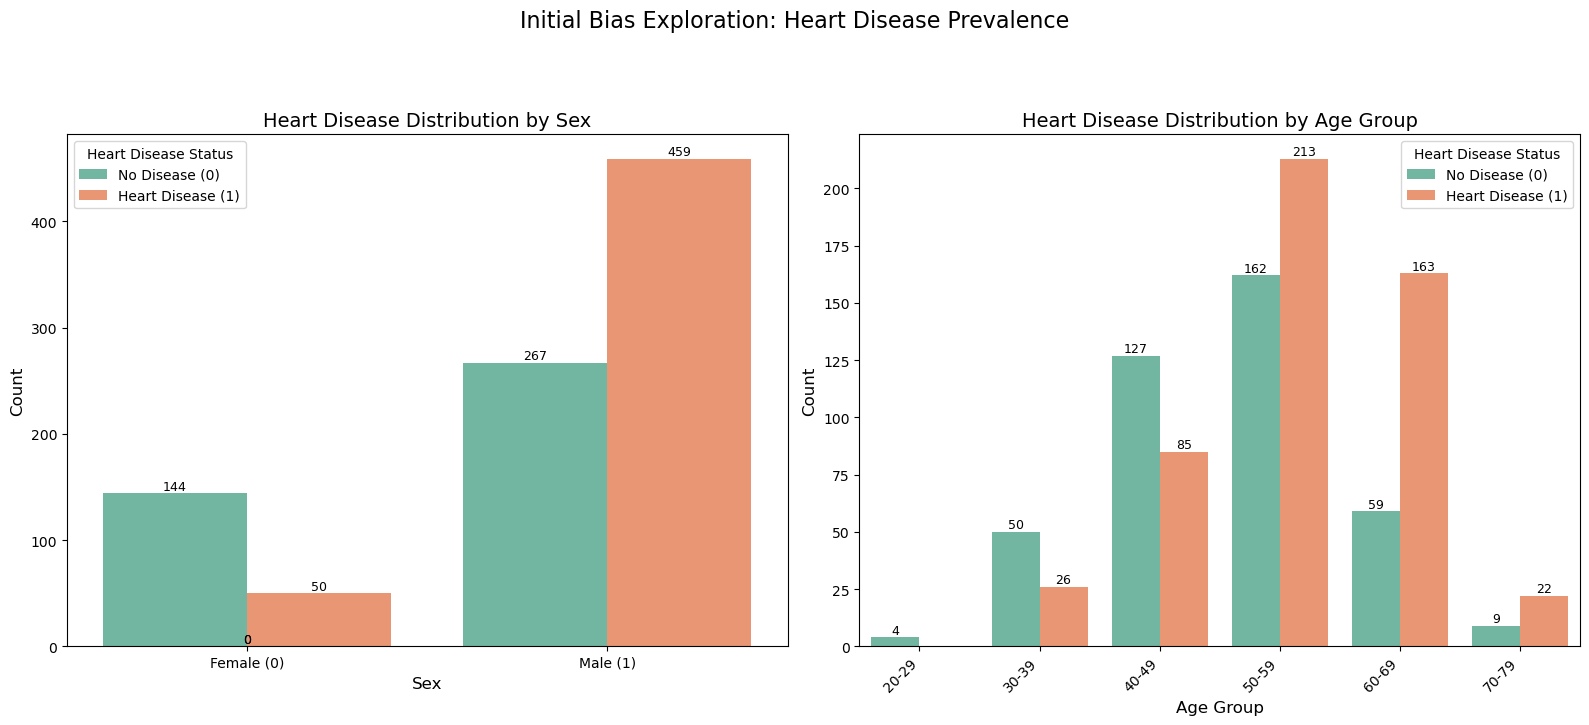


--- Script Finished ---


In [32]:
if not df.empty:
    print("Generating visualizations...")
    
    plt.figure(figsize=(16, 7)) # Adjusted figure size for better layout
    plt.suptitle('Initial Bias Exploration: Heart Disease Prevalence', fontsize=16, y=1.03)
    
    plot_count = 0 # To manage subplot indexing if some plots are skipped
    
    # Plot 1: Target distribution by Sex
    if 'sex' in df.columns and 'target' in df.columns:
        plot_count += 1
        plt.subplot(1, 2, plot_count) # Use plot_count for subplot index
        ax1 = sns.countplot(x='sex', hue='target', data=df, palette=['#66c2a5','#fc8d62'])
        plt.title('Heart Disease Distribution by Sex', fontsize=14)
        plt.xlabel('Sex', fontsize=12) # Simplified label
        plt.ylabel('Count', fontsize=12)
        
        # Check unique values in 'sex' to set xticks and labels dynamically
        sex_unique_values = sorted(df['sex'].unique())
        sex_labels = []
        if 0 in sex_unique_values:
            sex_labels.append('Female (0)')
        if 1 in sex_unique_values:
            sex_labels.append('Male (1)')
        
        # Ensure ticks match the available unique values
        # If only one gender is present after cleaning, this will handle it.
        current_ticks = []
        current_labels = []
        if 0 in sex_unique_values:
            current_ticks.append(sex_unique_values.index(0) if len(sex_unique_values) > 1 and 0 in sex_unique_values else 0)
            current_labels.append('Female (0)')
        if 1 in sex_unique_values:
            current_ticks.append(sex_unique_values.index(1) if len(sex_unique_values) > 1 and 1 in sex_unique_values else (1 if 0 not in sex_unique_values else len(current_ticks))) # Adjust tick position
            current_labels.append('Male (1)')

        if current_ticks: # Only set if there are valid ticks
            plt.xticks(ticks=current_ticks, labels=current_labels)


        handles, legend_labels = ax1.get_legend_handles_labels()
        # Ensure legend labels match actual target values if they are not just 0 and 1
        target_legend_map = {str(val): f'Target {val}' for val in sorted(df['target'].unique())}
        if '0' in legend_labels and '1' in legend_labels: # Common case
             ax1.legend(handles, ['No Disease (0)', 'Heart Disease (1)'], title='Heart Disease Status')
        else: # Fallback if target values are different
            ax1.legend(handles, [target_legend_map.get(lbl, lbl) for lbl in legend_labels], title='Heart Disease Status')
    
        # Add annotations for countplot with hue
        for p in ax1.patches:
            ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=9)
    else:
        print("Skipping 'Heart Disease Distribution by Sex' plot: 'sex' or 'target' column missing.")

    # Plot 2: Target distribution by Age Group
    if 'age' in df.columns and 'target' in df.columns:
        plot_count += 1
        plt.subplot(1, 2, plot_count) # Use plot_count for subplot index
        # Create age bins for visualization
        # Determine min and max age to make bins more robust
        min_age = df['age'].min() if pd.notna(df['age'].min()) else 20
        max_age = df['age'].max() if pd.notna(df['age'].max()) else 80
        
        # Ensure bins cover the range of data
        age_bins = list(range(int(min_age // 10 * 10), int(max_age // 10 * 10) + 20, 10))
        if not age_bins or len(age_bins) < 2 : # Fallback if age range is too small or data is odd
            age_bins = [20, 30, 40, 50, 60, 70, 80]

        age_labels = [f'{age_bins[i]}-{age_bins[i+1]-1}' for i in range(len(age_bins)-1)]
        
        # Create a temporary 'age_group' column for plotting
        df_plot = df.copy() # Work on a copy for adding plotting-specific columns
        df_plot['age_group'] = pd.cut(df_plot['age'], bins=age_bins, labels=age_labels, right=False, include_lowest=True)
    
        ax2 = sns.countplot(x='age_group', hue='target', data=df_plot, order=age_labels, palette=['#66c2a5','#fc8d62'])
        plt.title('Heart Disease Distribution by Age Group', fontsize=14)
        plt.xlabel('Age Group', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.xticks(rotation=45, ha="right")
        
        handles, legend_labels = ax2.get_legend_handles_labels()
        if '0' in legend_labels and '1' in legend_labels:
             ax2.legend(handles, ['No Disease (0)', 'Heart Disease (1)'], title='Heart Disease Status')
        else:
            ax2.legend(handles, [target_legend_map.get(lbl, lbl) for lbl in legend_labels], title='Heart Disease Status')
    
        # Add annotations
        for p in ax2.patches:
            if p.get_height() > 0: # Only annotate if height is > 0
                ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=9)
    else:
        print("Skipping 'Heart Disease Distribution by Age Group' plot: 'age' or 'target' column missing.")

    if plot_count > 0: # Only show plot if at least one subplot was created
        plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
        plt.show()
    else:
        print("No visualizations were generated as required columns were missing.")

else:
    print("Skipping visualizations as DataFrame is empty.")

print("\n--- Script Finished ---")
# </cell>



--- Generating Visualization: Age Distribution by Heart Disease Status ---


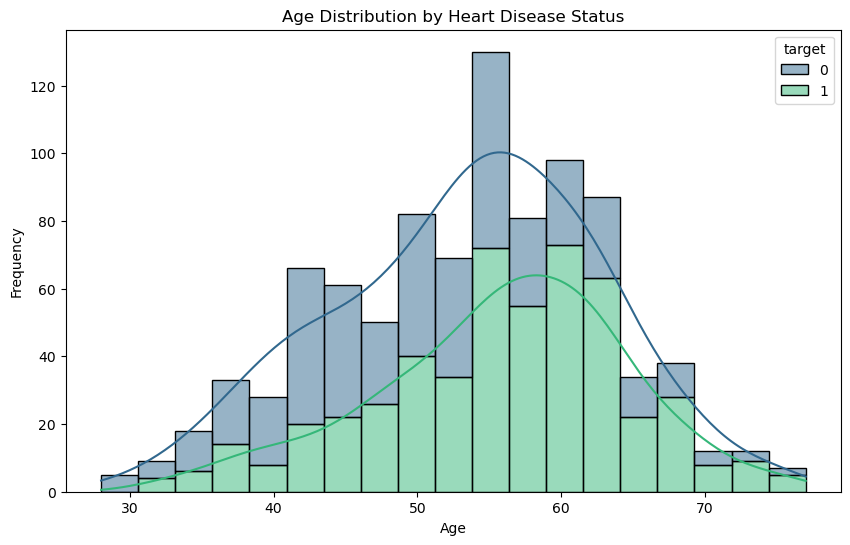

In [33]:
 #Data Visualization - Age Distribution
if not df.empty and 'age' in df.columns and 'target' in df.columns:
    print("\n--- Generating Visualization: Age Distribution by Heart Disease Status ---")
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='age', kde=True, hue='target', palette='viridis', multiple="stack")
    plt.title('Age Distribution by Heart Disease Status')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    handles, _ = plt.gca().get_legend_handles_labels() 
    if handles:
        legend_labels = ['No Disease (0)', 'Heart Disease (1)']
        # Check number of unique target values to adjust legend
        unique_targets = sorted(df['target'].unique())
        if len(unique_targets) == 2 and 0 in unique_targets and 1 in unique_targets:
            plt.legend(handles, legend_labels, title='Heart Disease Status')
        elif len(unique_targets) == 1:
             plt.legend(handles, [f'Status ({unique_targets[0]})'], title='Heart Disease Status')
        else: # Fallback for unexpected target values
            plt.legend(title='Heart Disease Status') 
    plt.show()
else:
    print("Skipping Age Distribution plot: 'age' or 'target' column missing or DataFrame empty.")


--- Generating Visualization: Heart Disease Distribution by Sex ---


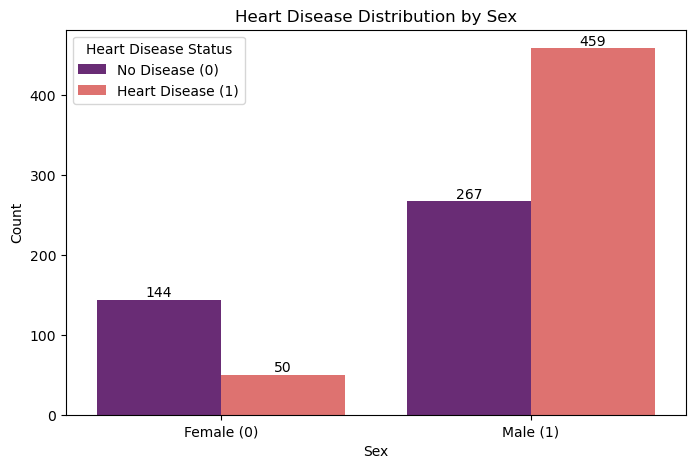

In [34]:
#Data Visualization - Sex Distribution
if not df.empty and 'sex' in df.columns and 'target' in df.columns:
    print("\n--- Generating Visualization: Heart Disease Distribution by Sex ---")
    plt.figure(figsize=(8, 5))
    ax_sex = sns.countplot(data=df, x='sex', hue='target', palette='magma')
    plt.title('Heart Disease Distribution by Sex')
    plt.xlabel('Sex')
    plt.ylabel('Count')
    
    # Add bar labels
    try:
        for container in ax_sex.containers:
            ax_sex.bar_label(container, fmt='%d')
    except AttributeError: # Older matplotlib might not have bar_label on container
        for p in ax_sex.patches:
            ax_sex.annotate(f'{int(p.get_height())}', 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 5), 
                           textcoords = 'offset points')

    plt.xticks([0, 1], ['Female (0)', 'Male (1)'])
    handles, _ = ax_sex.get_legend_handles_labels()
    if handles:
        unique_targets = sorted(df['target'].unique())
        if len(unique_targets) == 2 and 0 in unique_targets and 1 in unique_targets:
            ax_sex.legend(handles, ['No Disease (0)', 'Heart Disease (1)'], title='Heart Disease Status')
        elif len(unique_targets) == 1:
             ax_sex.legend(handles, [f'Status ({unique_targets[0]})'], title='Heart Disease Status')
        else:
            ax_sex.legend(title='Heart Disease Status')
    plt.show()
else:
    print("Skipping Sex Distribution plot: 'sex' or 'target' column missing or DataFrame empty.")


--- Generating Visualization: Feature Correlation Matrix ---
--- No object columns to one-hot encode for correlation heatmap ---


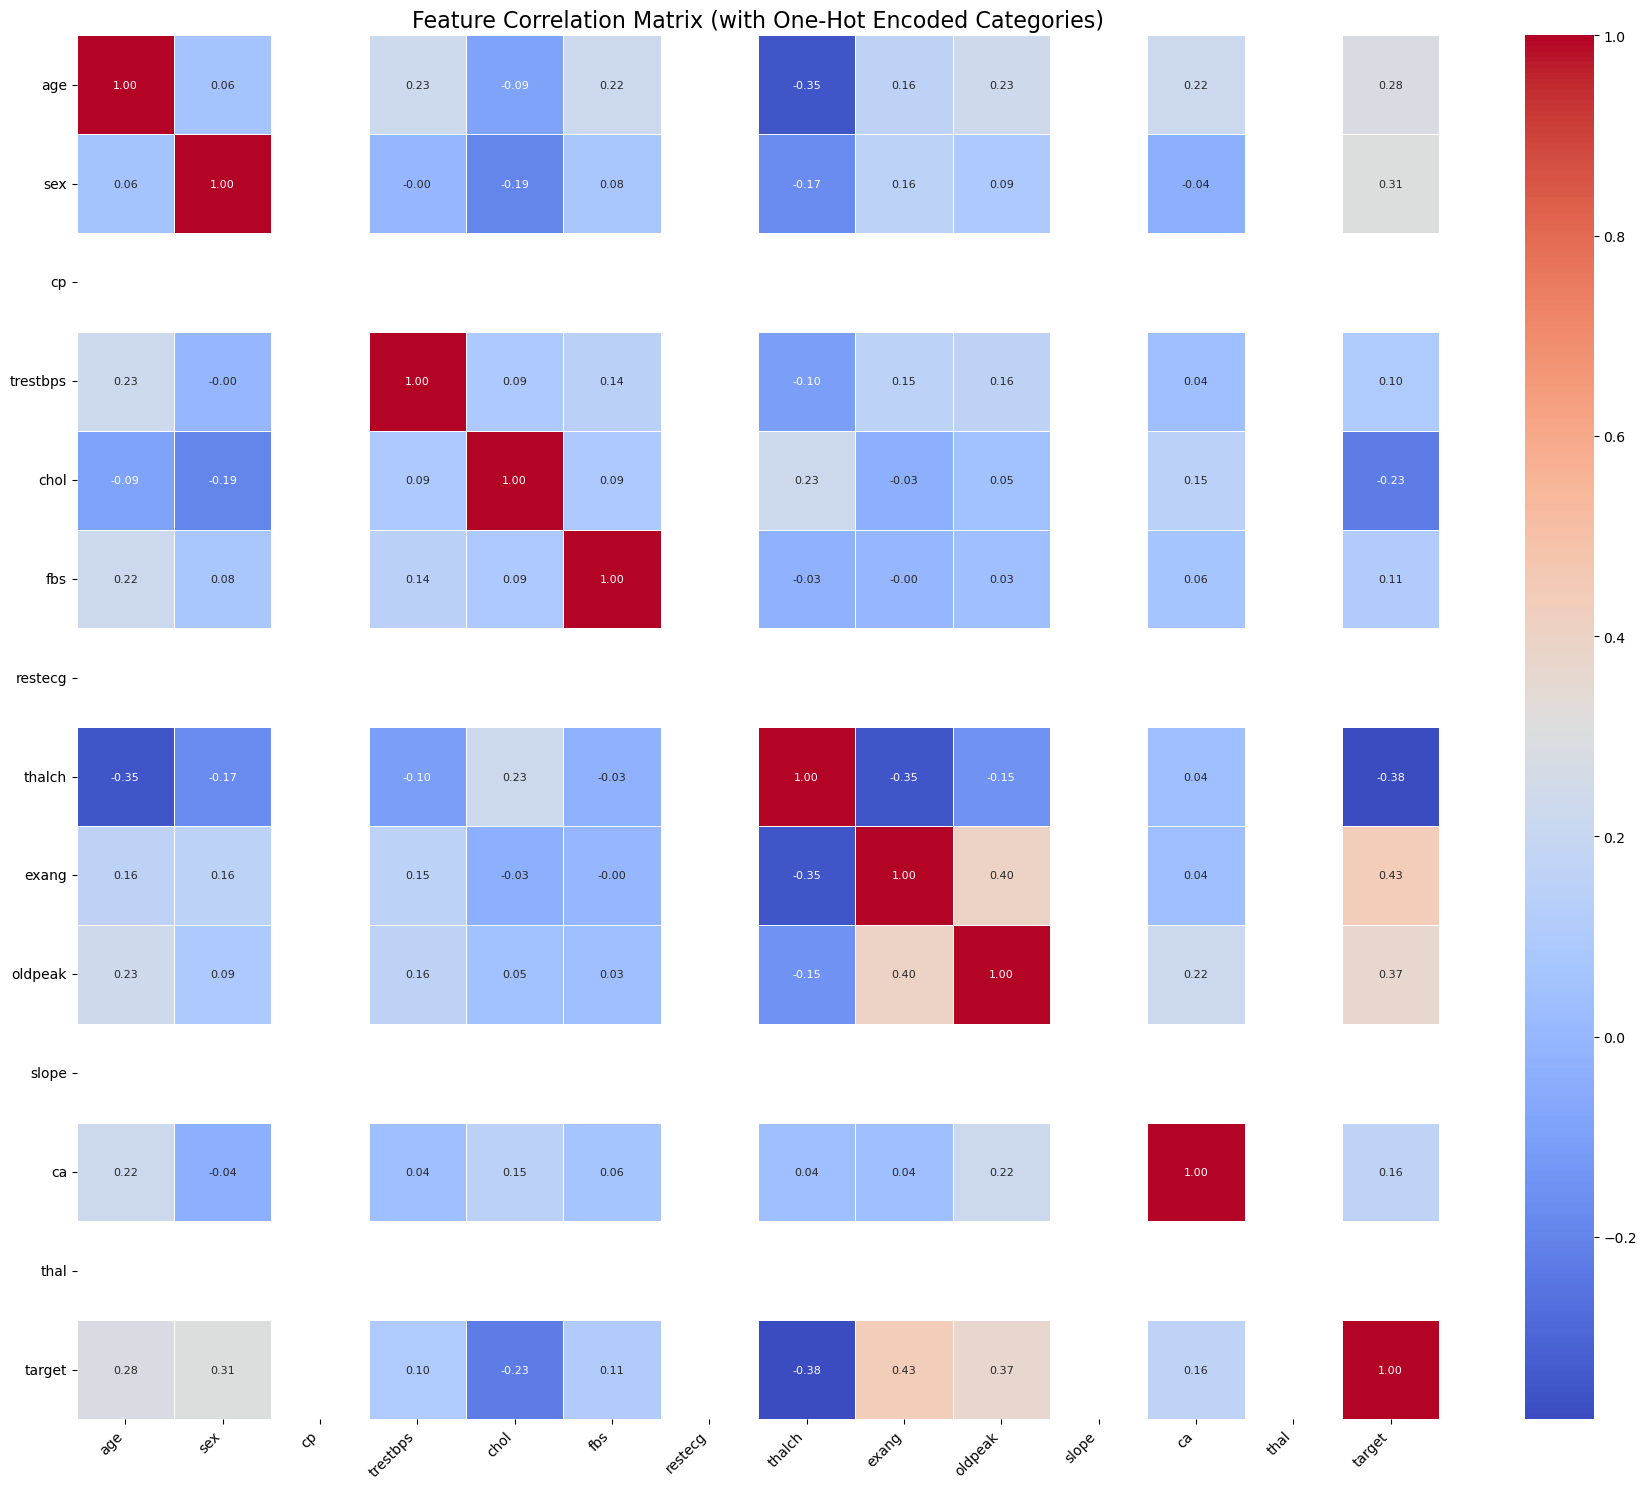

In [35]:
# Cell 12: Data Visualization - Correlation Heatmap
if not df.empty:
    print("\n--- Generating Visualization: Feature Correlation Matrix ---")
    # Drop non-numeric or identifier columns before correlation
    # 'id' and 'dataset' are often non-numeric or not useful for correlation.
    df_for_corr = df.drop(columns=['id', 'dataset'], errors='ignore').copy()

    # Identify object columns that need one-hot encoding
    object_cols_for_corr = df_for_corr.select_dtypes(include='object').columns
    if not object_cols_for_corr.empty:
        print(f"--- One-hot encoding for correlation heatmap: {list(object_cols_for_corr)} ---")
        df_for_corr = pd.get_dummies(df_for_corr, columns=list(object_cols_for_corr), drop_first=True, dummy_na=False)
    else:
        print("--- No object columns to one-hot encode for correlation heatmap ---")

    if not df_for_corr.empty and df_for_corr.shape[1] > 1:
        plt.figure(figsize=(max(18, df_for_corr.shape[1]*0.7), max(15, df_for_corr.shape[1]*0.6))) # Dynamic figure size
        correlation_matrix = df_for_corr.corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, 
                    annot_kws={"size": 7 if df_for_corr.shape[1] > 25 else 8})
        plt.title('Feature Correlation Matrix (with One-Hot Encoded Categories)', fontsize=16)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        plt.tight_layout()
        plt.show()
    elif df_for_corr.shape[1] <=1:
        print("Skipping correlation heatmap: Not enough columns for correlation after processing.")
    else:
        print("Skipping correlation heatmap: DataFrame for correlation is empty.")
else:
    print("Skipping Correlation Heatmap: DataFrame empty.")


--- Generating Visualization: Cholesterol Levels by Sex and Heart Disease Status ---


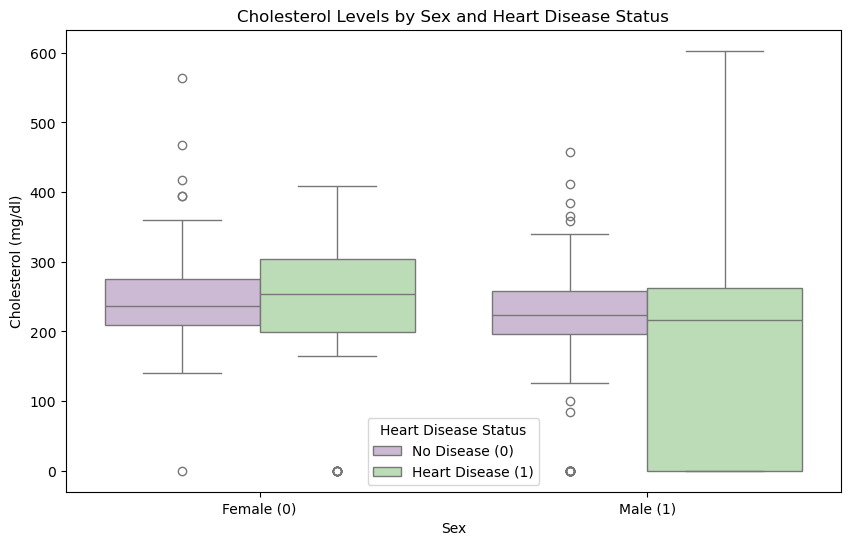

In [36]:
# Cell 13: Data Visualization - Cholesterol by Sex and Target
if not df.empty and 'sex' in df.columns and 'chol' in df.columns and 'target' in df.columns:
    print("\n--- Generating Visualization: Cholesterol Levels by Sex and Heart Disease Status ---")
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='sex', y='chol', hue='target', palette='PRGn')
    plt.title('Cholesterol Levels by Sex and Heart Disease Status')
    plt.xlabel('Sex')
    plt.ylabel('Cholesterol (mg/dl)')
    plt.xticks([0, 1], ['Female (0)', 'Male (1)'])
    handles, _ = plt.gca().get_legend_handles_labels()
    if handles:
        unique_targets = sorted(df['target'].unique())
        if len(unique_targets) == 2 and 0 in unique_targets and 1 in unique_targets:
            plt.legend(handles, ['No Disease (0)', 'Heart Disease (1)'], title='Heart Disease Status')
        elif len(unique_targets) == 1:
             plt.legend(handles, [f'Status ({unique_targets[0]})'], title='Heart Disease Status')
        else:
            plt.legend(title='Heart Disease Status')
    plt.show()
else:
    print("Skipping Cholesterol plot: 'sex', 'chol', or 'target' column missing or DataFrame empty.")


--- Generating Visualization: Max Heart Rate Distribution by Sex and Heart Disease Status ---


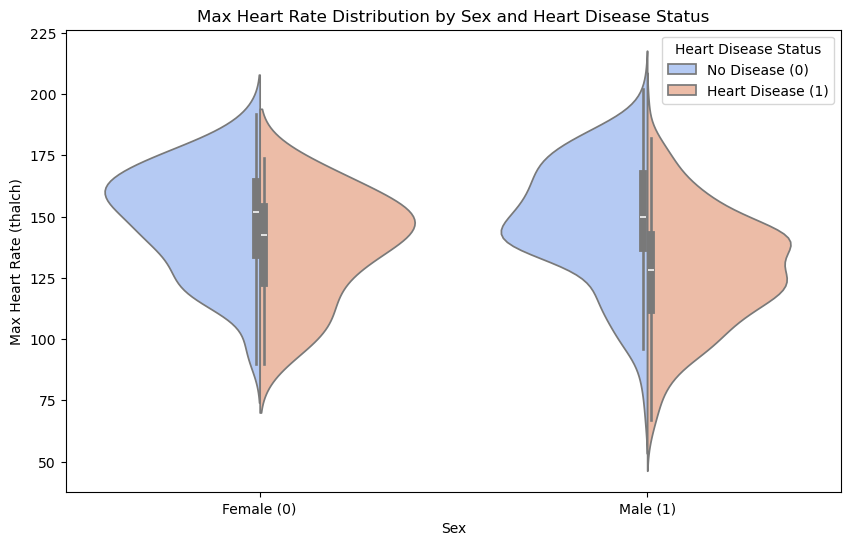


--- End of EDA and Initial Cleaning/Visualization Script ---


In [37]:
#Data Visualization - Max Heart Rate (thalch) by Sex and Target
if not df.empty and 'sex' in df.columns and 'thalch' in df.columns and 'target' in df.columns:
    print("\n--- Generating Visualization: Max Heart Rate Distribution by Sex and Heart Disease Status ---")
    plt.figure(figsize=(10, 6))
    if pd.api.types.is_numeric_dtype(df['thalch']):
        sns.violinplot(data=df, x='sex', y='thalch', hue='target', palette='coolwarm', split=True)
        plt.title('Max Heart Rate Distribution by Sex and Heart Disease Status')
        plt.xlabel('Sex')
        plt.ylabel('Max Heart Rate (thalch)')
        plt.xticks([0, 1], ['Female (0)', 'Male (1)'])
        handles, _ = plt.gca().get_legend_handles_labels()
        if handles:
            unique_targets = sorted(df['target'].unique())
            if len(unique_targets) == 2 and 0 in unique_targets and 1 in unique_targets:
                plt.legend(handles, ['No Disease (0)', 'Heart Disease (1)'], title='Heart Disease Status')
            elif len(unique_targets) == 1:
                 plt.legend(handles, [f'Status ({unique_targets[0]})'], title='Heart Disease Status')
            else:
                plt.legend(title='Heart Disease Status')
    else:
        plt.text(0.5, 0.5, "'thalch' column is not numeric or contains non-convertible values.",
                 horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes,
                 bbox=dict(facecolor='red', alpha=0.2))
        plt.title('Max Heart Rate Distribution (Error)')
        print("Skipping violinplot for 'thalch' as it's not suitable (e.g., not numeric after cleaning).")
    plt.show()
else:
    print("Skipping Max Heart Rate plot: 'sex', 'thalch', or 'target' column missing or DataFrame empty.")
# </cell>

# Cell 15: Script Finish (End of EDA and Initial Cleaning Visualizations)
print("\n--- End of EDA and Initial Cleaning/Visualization Script ---")
# At this point, 'df' should be the cleaned DataFrame ready for further processing or modeling.
# </cell>

In [38]:
# Cell 16: Data Preparation for Modeling
# This cell assumes 'df' is the cleaned DataFrame from the previous cells.
# If running this cell independently, ensure 'df' is loaded and cleaned appropriately.

# Additional imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer # Added for final imputation

print("\n--- Starting Chunk 1: Data Preparation for Modeling ---")

# Stand-in df definition (for independent execution if 'df' is not in environment)
# IMPORTANT: In a sequential notebook run, the 'df' from previous cells should be used.
if 'df' not in locals() or df.empty:
    print("WARNING: 'df' not found or is empty. Using a stand-in DataFrame for demonstration.")
    print("Ensure the previous cells (1-15) have been run to generate the cleaned 'df'.")
    data_standin = {
        'age': np.random.randint(29, 77, 300),
        'sex': np.random.randint(0, 2, 300), # 0 for Female, 1 for Male
        'cp': np.random.choice([0, 1, 2, 3], 300), # Assuming cp is numerically encoded after cleaning
        'trestbps': np.random.randint(90, 200, 300),
        'chol': np.random.randint(120, 500, 300),
        'fbs': np.random.randint(0, 2, 300),      # 0 or 1
        'restecg': np.random.choice([0, 1, 2], 300), # Assuming restecg is numerically encoded
        'thalch': np.random.randint(70, 200, 300),
        'exang': np.random.randint(0, 2, 300),     # 0 or 1
        'oldpeak': np.random.rand(300) * 4,
        'slope': np.random.choice([0, 1, 2], 300), # Assuming slope is numerically encoded
        'ca': np.random.randint(0, 4, 300),        # 0, 1, 2, 3
        'thal': np.random.choice([0, 1, 2, 3], 300), # Assuming thal is numerically encoded (e.g., 0 for unknown/NaN, 1 normal, 2 fixed, 3 reversable)
        'target': np.random.randint(0, 2, 300),    # 0 for No Disease, 1 for Disease
        'id': range(300), # Will be dropped
        'dataset': ['Cleveland'] * 300 # Will be dropped
    }
    df = pd.DataFrame(data_standin)
    # Ensure categorical columns that are numerically encoded are treated as categories by converting to object or category type
    # This is crucial if OneHotEncoder is to be used on them.
    # Based on the cleaning script, some might already be int but represent categories.
    # The `categorical_features` list later will define how they are treated.
    print("Stand-in DataFrame created. Its 'cp', 'restecg', 'slope', 'thal' are numeric codes.")
else:
    print("Using 'df' from the previous operations for modeling preparation.")

# --- 1. Feature Separation (X and y) ---
if 'target' not in df.columns:
    print("Error: 'target' column not found. Please ensure it's correctly named in your DataFrame.")
    # exit() # Or handle error appropriately in a notebook
    X, y = pd.DataFrame(), pd.Series() # Assign empty to prevent further errors in this cell
else:
    # Drop 'id' and 'dataset' as they are not features for modeling
    columns_to_drop = ['target']
    if 'id' in df.columns:
        columns_to_drop.append('id')
    if 'dataset' in df.columns:
        columns_to_drop.append('dataset')
    
    X = df.drop(columns=columns_to_drop, errors='ignore')
    y = df['target']

print(f"Shape of features X: {X.shape}")
print(f"Shape of target y: {y.shape}")
if not X.empty:
    print(f"Columns in X: {X.columns.tolist()}")

# --- 2. Identify Feature Types ---
# These lists should reflect the state of 'df' AFTER the cleaning in Cells 1-9.
# Numerical features (truly continuous or discrete numeric)
numerical_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']

# Categorical features:
# These include features that are binary (like 'sex', 'fbs', 'exang' which are 0/1 int after cleaning)
# and features with multiple categories (like 'cp', 'restecg', 'slope', 'thal', 'ca').
# After cleaning (Cell 6), 'cp', 'restecg', 'slope', 'thal' might be int if successfully converted,
# or object if conversion failed (e.g., contained 'Unknown').
# 'ca' is converted to int in Cell 8.
# OneHotEncoder can handle both numeric categorical and string categorical features.
# It's good practice to ensure these are of a consistent type (e.g., all object/category or all int codes)
# before passing to the ColumnTransformer, or ensure the transformer handles mixed types if applicable.

# For robustness, let's check dtypes from the *actual* df:
categorical_features = []
if not X.empty:
    for col in ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']:
        if col in X.columns:
            # If a column intended as categorical is float (e.g. due to NaNs before int conversion),
            # it might need special handling or ensure it's int/object.
            # For now, we assume they are appropriate for OHE (int codes or object/string).
            categorical_features.append(col)
else:
    print("X is empty, cannot identify feature types dynamically.")


# Verify that all listed features are in X's columns and remove if not
if not X.empty:
    numerical_features = [f for f in numerical_features if f in X.columns]
    categorical_features = [f for f in categorical_features if f in X.columns]

    # Ensure no overlap between numerical and categorical (though logic above should prevent it)
    common_features = list(set(numerical_features) & set(categorical_features))
    if common_features:
        print(f"Warning: Features found in both numerical and categorical lists: {common_features}. Removing from categorical.")
        categorical_features = [f for f in categorical_features if f not in common_features]
else:
    numerical_features = [] # Ensure empty if X is empty
    categorical_features = []


print(f"\nIdentified Numerical Features: {numerical_features}")
print(f"Identified Categorical Features: {categorical_features}")

# --- 3. Train-Test Split ---
if not X.empty and not y.empty:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )
    print(f"\nTraining set shape: X_train-{X_train.shape}, y_train-{y_train.shape}")
    print(f"Test set shape: X_test-{X_test.shape}, y_test-{y_test.shape}")
else:
    print("\nSkipping train-test split as X or y is empty.")
    # Create empty placeholders to avoid errors in subsequent lines if this cell is run partially
    X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(), pd.Series()


# --- 4. Preprocessing Pipeline ---
# Create preprocessing pipelines for numerical and categorical features
# handle_unknown='ignore': new categories in test set will be all zeros
# drop='first': helps reduce multicollinearity for OHE. Set to None or 'if_binary' for different handling.
# sparse_output=False: returns dense array, easier for DataFrame conversion. Default is True (sparse matrix).
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first' if len(categorical_features)>0 else None, sparse_output=False)

# Create a column transformer
# Ensure lists are not empty before creating transformers for them
transformers_list = []
if numerical_features: # Only add if there are numerical features
    transformers_list.append(('num', numerical_transformer, numerical_features))
if categorical_features: # Only add if there are categorical features
    transformers_list.append(('cat', categorical_transformer, categorical_features))

if not transformers_list:
    print("Warning: No features identified for preprocessing. Preprocessor will be empty.")
    preprocessor = None # Or a dummy preprocessor
    X_train_processed, X_test_processed = X_train.copy() if 'X_train' in locals() else pd.DataFrame(), X_test.copy() if 'X_test' in locals() else pd.DataFrame() # No processing
else:
    preprocessor = ColumnTransformer(
        transformers=transformers_list,
        remainder='passthrough' # Columns not in numerical_features or categorical_features will be passed through.
                               # Ensure all relevant features are in one of these lists.
    )

    # Apply preprocessing: Fit on training data, transform both train and test
    if 'X_train' in locals() and not X_train.empty and preprocessor:
        X_train_processed = preprocessor.fit_transform(X_train)
        if 'X_test' in locals() and not X_test.empty:
            X_test_processed = preprocessor.transform(X_test)
        else:
            X_test_processed = np.array([]) # Ensure it's an empty array if X_test is empty
            print("X_test is empty, X_test_processed set to empty array.")

        # --- ADDED: Final Imputation Step to remove any lingering NaNs ---
        # This step is crucial if 'passthrough' columns had NaNs or if any previous step unexpectedly created NaNs.
        final_imputer = SimpleImputer(strategy='constant', fill_value=0) # Using constant fill_value=0 is safer for mixed-type processed data

        if X_train_processed.size > 0 : # Check if there's data to impute
            X_train_processed = final_imputer.fit_transform(X_train_processed)
            print("\nApplied final imputation to X_train_processed.")
            if X_test_processed.size > 0:
                X_test_processed = final_imputer.transform(X_test_processed)
                print("Applied final imputation to X_test_processed.")
            else:
                print("X_test_processed is empty, skipping final imputation for it.")
        else:
            print("X_train_processed is empty, skipping final imputation.")
        # --- END OF ADDED IMPUTATION STEP ---


        # Get feature names after OHE for better interpretation
        try:
            # get_feature_names_out is preferred. Fallback for older sklearn.
            if hasattr(preprocessor, 'get_feature_names_out'):
                feature_names_out = preprocessor.get_feature_names_out()
            else: # Fallback for older scikit-learn versions
                # Manual construction of feature names (more complex)
                feature_names_out = []
                # This simplified fallback assumes transformers directly output feature names or are named in order.
                # For ColumnTransformer with OHE, get_feature_names_out is much more reliable.
                for name, trans_obj, Pcols in preprocessor.transformers_:
                    if trans_obj == 'drop':
                        continue
                    if trans_obj == 'passthrough':
                        # For passthrough, need to get actual column names if X_train is a DataFrame
                        if isinstance(X_train, pd.DataFrame):
                            # Identify passthrough columns by finding those not in num_features or cat_features
                            processed_cols = numerical_features + categorical_features
                            passthrough_cols = [col for col in X_train.columns if col not in processed_cols]
                            feature_names_out.extend(passthrough_cols)
                        else: # If X_train is not a DataFrame, cannot get names for passthrough
                            # Add placeholders or handle based on expected number of passthrough columns
                            num_passthrough = X_train.shape[1] - len(numerical_features) - len(categorical_features) # Approximate
                            feature_names_out.extend([f"passthrough_{i}" for i in range(num_passthrough)])
                        continue
                    # For named transformers like 'num' and 'cat'
                    if hasattr(trans_obj, 'get_feature_names_out'): # Typically for OneHotEncoder
                         # Need to pass the original column names for this transformer
                        feature_names_out.extend(trans_obj.get_feature_names_out(Pcols))
                    elif hasattr(trans_obj, 'get_feature_names'): # Older OHE version
                        feature_names_out.extend(trans_obj.get_feature_names(Pcols))
                    else: # For transformers like StandardScaler
                        feature_names_out.extend(Pcols)


            print(f"\nProcessed feature count: {len(feature_names_out)}")
            # print(f"Processed feature names: {feature_names_out}") # Uncomment to see all names

            # Convert processed arrays back to DataFrames (optional, but useful for inspection)
            # Ensure X_train_processed has data and feature_names_out is not empty
            if X_train_processed.size > 0 and feature_names_out:
                 X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names_out, index=X_train.index if 'X_train' in locals() else None)
                 print("\nFirst 5 rows of processed training data (X_train_processed_df):")
                 print(X_train_processed_df.head())
            else:
                print("\nSkipping creation of X_train_processed_df as processed data or feature names are empty.")
                X_train_processed_df = pd.DataFrame() # Ensure it exists as an empty df

            if X_test_processed.size > 0 and feature_names_out:
                 X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names_out, index=X_test.index if 'X_test' in locals() else None)
                 # print("\nFirst 5 rows of processed test data (X_test_processed_df):") # Optional
                 # print(X_test_processed_df.head())
            else:
                # print("\nSkipping creation of X_test_processed_df as processed data or feature names are empty.")
                X_test_processed_df = pd.DataFrame() # Ensure it exists as an empty df


        except Exception as e:
            print(f"Error getting feature names or creating processed DataFrames: {e}")
            print("X_train_processed and X_test_processed are NumPy arrays.")
            print(f"Shape of X_train_processed: {X_train_processed.shape if 'X_train_processed' in locals() and hasattr(X_train_processed, 'shape') else 'Not defined or not an array'}")
            X_train_processed_df = pd.DataFrame() # Ensure it exists
            X_test_processed_df = pd.DataFrame()  # Ensure it exists

    elif preprocessor is None:
        print("Preprocessor was not created (no features to process). Using original data.")
        # Ensure these variables exist if preprocessor is None
        X_train_processed = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
        X_test_processed = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test
        X_train_processed_df = X_train.copy() if 'X_train' in locals() else pd.DataFrame()
        X_test_processed_df = X_test.copy() if 'X_test' in locals() else pd.DataFrame()

    else:
        print("Skipping preprocessing as training data is empty or preprocessor not defined.")
        # Ensure these variables exist as empty numpy arrays / DataFrames
        X_train_processed, X_test_processed = np.array([]), np.array([])
        X_train_processed_df, X_test_processed_df = pd.DataFrame(), pd.DataFrame()


print("\n--- Chunk 1: Data Preparation for Modeling Finished ---")
# The variables X_train_processed, X_test_processed, y_train, y_test,
# and the 'preprocessor' are now ready for the next chunk (model training).
# Also, X_train, X_test (original pre-transform) are useful for linking back.
# </cell>



--- Starting Chunk 1: Data Preparation for Modeling ---
Using 'df' from the previous operations for modeling preparation.
Shape of features X: (920, 13)
Shape of target y: (920,)
Columns in X: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

Identified Numerical Features: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
Identified Categorical Features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

Training set shape: X_train-(690, 13), y_train-(690,)
Test set shape: X_test-(230, 13), y_test-(230,)

Applied final imputation to X_train_processed.
Applied final imputation to X_test_processed.

Processed feature count: 11
Error getting feature names or creating processed DataFrames: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
X_train_processed and X_test_processed are NumPy arrays.
Shape of X_train_processed: (690, 11)

--- Chunk 1: Data Preparation for Modeli


---  Model Training and Overall Evaluation ---
Training and test data from Cell 16 seem to be available.

--- Defining Models ---
Logistic Regression model defined: LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
Random Forest model defined: RandomForestClassifier(random_state=42)

---  Training Models ---
Logistic Regression model trained successfully.
Random Forest model trained successfully.

---  Making Predictions ---
Predictions made for both models.

---  Overall Model Evaluation ---

--- Overall Evaluation: Logistic Regression ---
Accuracy: 0.8000
ROC AUC: 0.8701
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.77      0.77       103
           1       0.81      0.83      0.82       127

    accuracy                           0.80       230
   macro avg       0.80      0.80      0.80       230
weighted avg       0.80      0.80      0.80       230

Confusion Matrix:
 [[ 79  24]
 [ 22 105]]

--- 

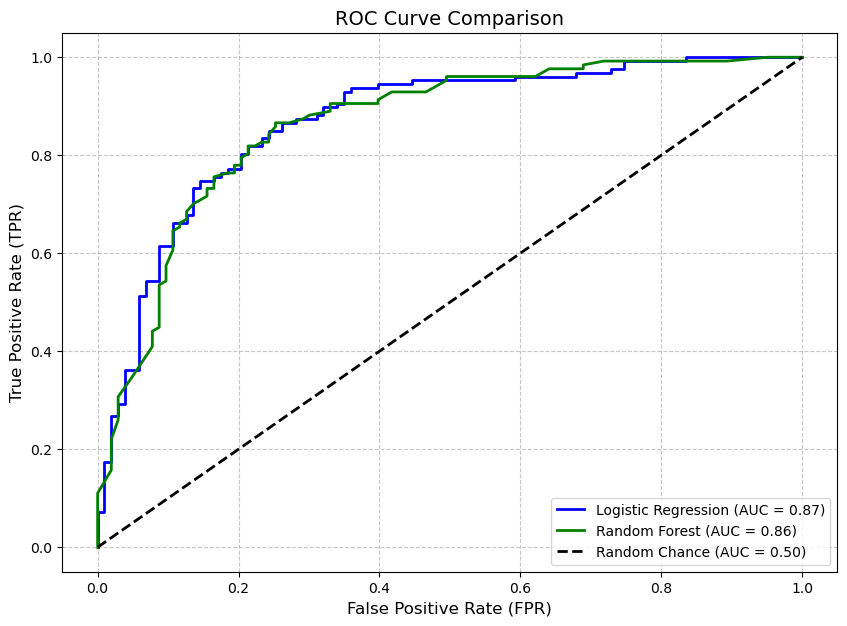


---  Model Training and Overall Evaluation Finished ---


In [39]:
#  Model Training and Overall Evaluation
# This cell assumes variables from Cell 16 (Chunk 1) are available:
# X_train_processed, X_test_processed, y_train, y_test
# It also assumes matplotlib, seaborn, numpy, pandas, and warnings are already imported.

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
# Warnings filterwarnings('ignore') should ideally be at the top of the notebook (Cell 1)

print("\n---  Model Training and Overall Evaluation ---")

# --- Verify Data Availability from Chunk 1 (Cell 16) ---
if ('X_train_processed' not in locals() or not isinstance(X_train_processed, np.ndarray) or
    'X_test_processed' not in locals() or not isinstance(X_test_processed, np.ndarray) or
    'y_train' not in locals() or not isinstance(y_train, pd.Series) or
    'y_test' not in locals() or not isinstance(y_test, pd.Series)):
    print("Error: Training/test data from Chunk 1 (Cell 16) not found or not in expected format.")
    print("Please ensure Cell 16 has been run successfully and variables are correctly populated.")
    # Fallback: Create minimal dummy data for demonstration if running isolated.
    # This is NOT for actual analysis and will likely produce meaningless results.
    if 'X_train_processed' not in locals() or 'X_test_processed' not in locals() or 'y_train' not in locals() or 'y_test' not in locals():
        print("Using minimal DUMMY data for demonstration as critical variables are missing.")
        num_features_standin = 10 # Example number of features after preprocessing
        num_train_samples = 225
        num_test_samples = 75
        X_train_processed = np.random.rand(num_train_samples, num_features_standin)
        X_test_processed = np.random.rand(num_test_samples, num_features_standin)
        y_train = pd.Series(np.random.randint(0, 2, num_train_samples))
        y_test = pd.Series(np.random.randint(0, 2, num_test_samples))
else:
    print("Training and test data from Cell 16 seem to be available.")


# --- 1. Model Definitions ---
print("\n--- Defining Models ---")
# Define Logistic Regression model with increased max_iter for convergence
log_reg = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear') # Added solver for potential compatibility
# Define Random Forest model
rand_forest = RandomForestClassifier(random_state=42, n_estimators=100)

print(f"Logistic Regression model defined: {log_reg}")
print(f"Random Forest model defined: {rand_forest}")

# --- 2. Model Training ---
print("\n---  Training Models ---")
models_trained = False
if 'X_train_processed' in locals() and hasattr(X_train_processed, 'shape') and X_train_processed.shape[0] > 0 and X_train_processed.shape[1] > 0:
    if 'y_train' in locals() and y_train.shape[0] > 0 :
        try:
            log_reg.fit(X_train_processed, y_train)
            print("Logistic Regression model trained successfully.")

            rand_forest.fit(X_train_processed, y_train)
            print("Random Forest model trained successfully.")
            models_trained = True
        except Exception as e:
            print(f"An error occurred during model training: {e}")
            print("Please check the preprocessed data and model parameters.")
    else:
        print("Skipping model training as y_train is not available or empty.")
else:
    print("Skipping model training as X_train_processed is not available, empty, or has no features.")


# --- 3. Predictions ---
# Initialize prediction variables to avoid errors if training fails
y_pred_log_reg = np.array([])
y_prob_log_reg = np.array([])
y_pred_rand_forest = np.array([])
y_prob_rand_forest = np.array([])

if models_trained and 'X_test_processed' in locals() and hasattr(X_test_processed, 'shape') and X_test_processed.shape[0] > 0 and X_test_processed.shape[1] > 0:
    print("\n---  Making Predictions ---")
    # Predictions for class labels
    y_pred_log_reg = log_reg.predict(X_test_processed)
    y_pred_rand_forest = rand_forest.predict(X_test_processed)

    # Predictions for probabilities (needed for ROC AUC)
    # predict_proba returns probabilities for each class [P(class_0), P(class_1)]
    # We need the probability of the positive class (class 1)
    y_prob_log_reg = log_reg.predict_proba(X_test_processed)[:, 1]
    y_prob_rand_forest = rand_forest.predict_proba(X_test_processed)[:, 1]
    print("Predictions made for both models.")
elif not models_trained:
    print("Skipping predictions as models were not trained.")
else:
    print("Skipping predictions as X_test_processed is not available, empty, or has no features.")


# --- 4. Overall Model Evaluation ---
print("\n---  Overall Model Evaluation ---")
if models_trained and 'y_test' in locals() and y_test.shape[0] > 0:
    # Check if y_test has more than one class for ROC AUC calculation
    y_test_has_multiple_classes = len(np.unique(y_test)) > 1

    print("\n--- Overall Evaluation: Logistic Regression ---")
    if y_pred_log_reg.size > 0: # Check if predictions were made
        print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
        if y_test_has_multiple_classes and y_prob_log_reg.size > 0:
            print(f"ROC AUC: {roc_auc_score(y_test, y_prob_log_reg):.4f}")
        else:
            print(f"ROC AUC: Not applicable (single class in y_test, or probabilities not available).")
        print("Classification Report:\n", classification_report(y_test, y_pred_log_reg, zero_division=0))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log_reg))
    else:
        print("Evaluation skipped for Logistic Regression as predictions were not made.")

    print("\n--- Overall Evaluation: Random Forest ---")
    if y_pred_rand_forest.size > 0: # Check if predictions were made
        print(f"Accuracy: {accuracy_score(y_test, y_pred_rand_forest):.4f}")
        if y_test_has_multiple_classes and y_prob_rand_forest.size > 0:
            print(f"ROC AUC: {roc_auc_score(y_test, y_prob_rand_forest):.4f}")
        else:
            print(f"ROC AUC: Not applicable (single class in y_test, or probabilities not available).")
        print("Classification Report:\n", classification_report(y_test, y_pred_rand_forest, zero_division=0))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rand_forest))
    else:
        print("Evaluation skipped for Random Forest as predictions were not made.")
else:
    print("Skipping model evaluation as models were not trained or y_test is empty.")


# --- 5. ROC Curve Visualization ---
print("\n---  Visualizing ROC Curves ---")
if (models_trained and 
    'y_test' in locals() and y_test.shape[0] > 0 and len(np.unique(y_test)) > 1 and 
    y_prob_log_reg.size > 0 and y_prob_rand_forest.size > 0):
    
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_log_reg)
    roc_auc_lr = roc_auc_score(y_test, y_prob_log_reg)

    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rand_forest)
    roc_auc_rf = roc_auc_score(y_test, y_prob_rand_forest)

    plt.figure(figsize=(10, 7))
    plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})', color='blue', lw=2)
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})', color='green', lw=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.50)', lw=2) # Random guess line
    
    plt.xlabel('False Positive Rate (FPR)', fontsize=12)
    plt.ylabel('True Positive Rate (TPR)', fontsize=12)
    plt.title('ROC Curve Comparison', fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()
else:
    print("ROC Curve visualization skipped due to: models not trained, y_test empty/single class, or probability predictions not available.")

print("\n---  Model Training and Overall Evaluation Finished ---")
# Key variables for the next chunk (Bias Analysis):
# y_test (true labels for the test set)
# y_pred_log_reg, y_prob_log_reg (Logistic Regression predictions)
# y_pred_rand_forest, y_prob_rand_forest (Random Forest predictions)
# We will also need X_test (original features before preprocessing from Cell 16) to get the sensitive attribute.
# </cell>


In [40]:
#  Bias Analysis (Subgroup Performance for Gender) - Calculations
# This cell assumes variables from Cell 16 (X, X_test, y_test) and 
# Cell 17 (y_pred_log_reg, y_prob_log_reg, y_pred_rand_forest, y_prob_rand_forest) are available.
# It also assumes pandas, numpy, and sklearn.metrics (accuracy, roc_auc, confusion_matrix) are imported.

print("\n--- Chunk 3: Bias Analysis (Subgroup Performance for Gender) ---")

# --- Define SENSITIVE_ATTRIBUTE ---
# This should be consistent with how 'sex' was handled in cleaning (0 for Female, 1 for Male)
SENSITIVE_ATTRIBUTE = 'sex'

# --- 0. Verify Data Availability ---
required_vars_exist = True
vars_to_check = ['X', 'X_test', 'y_test', 'y_pred_log_reg', 'y_prob_log_reg', 'y_pred_rand_forest', 'y_prob_rand_forest']
for var_name in vars_to_check:
    if var_name not in locals():
        print(f"Error: Essential variable '{var_name}' from previous Chunks not found.")
        required_vars_exist = False

if not required_vars_exist:
    print("Cannot proceed with Bias Analysis due to missing variables. Please run previous cells.")
    # Create dummy stand-ins for script to be syntactically valid if run in isolation (NOT FOR ANALYSIS)
    _n_test_samples = 75
    X = pd.DataFrame({SENSITIVE_ATTRIBUTE: np.random.randint(0, 2, _n_test_samples * 4), 'age': np.random.rand(_n_test_samples * 4)})
    X_test = pd.DataFrame({SENSITIVE_ATTRIBUTE: np.random.randint(0, 2, _n_test_samples), 'age': np.random.rand(_n_test_samples)}, index=range(_n_test_samples))
    y_test = pd.Series(np.random.randint(0, 2, _n_test_samples), index=X_test.index)
    y_pred_log_reg = np.random.randint(0, 2, _n_test_samples)
    y_prob_log_reg = np.random.rand(_n_test_samples)
    y_pred_rand_forest = np.random.randint(0, 2, _n_test_samples)
    y_prob_rand_forest = np.random.rand(_n_test_samples)
    print("Using minimal DUMMY data for Bias Analysis demonstration.")
else:
    print("Using variables from previous chunks for Bias Analysis.")


# --- 1. Get Original Sensitive Attribute for the Test Set ---
# We need the SENSITIVE_ATTRIBUTE column from the original X_test (before preprocessing)
# X_test should have been created in Cell 16 and have an index.
X_test_original_sensitive_attr = pd.DataFrame() # Initialize
y_test_series = pd.Series(dtype=float) # Initialize

if 'X_test' in locals() and isinstance(X_test, pd.DataFrame) and SENSITIVE_ATTRIBUTE in X_test.columns:
    X_test_original_sensitive_attr = X_test[[SENSITIVE_ATTRIBUTE]].copy()
    # Ensure y_test is a pandas Series with the same index as X_test for proper alignment
    if 'y_test' in locals() and hasattr(y_test, 'index') and X_test.index.equals(y_test.index):
        y_test_series = y_test.copy() # Already a series with correct index
    elif 'y_test' in locals(): # y_test might be a numpy array or series with different index
         y_test_series = pd.Series(y_test, index=X_test.index, name='target')
    else: # y_test not found
        print(f"Error: y_test not found. Cannot create y_test_series for bias analysis.")

    if not X_test_original_sensitive_attr.empty:
        print(f"\nSuccessfully retrieved '{SENSITIVE_ATTRIBUTE}' column for the test set.")
        print(f"Value counts for '{SENSITIVE_ATTRIBUTE}' in test set:\n{X_test_original_sensitive_attr[SENSITIVE_ATTRIBUTE].value_counts()}")
    else:
        print(f"Warning: '{SENSITIVE_ATTRIBUTE}' column retrieval resulted in an empty DataFrame.")
else:
    print(f"Error: Could not retrieve '{SENSITIVE_ATTRIBUTE}' from X_test. Ensure X_test is a DataFrame with this column and an index.")
    # Fallback to create dummy X_test_original_sensitive_attr and y_test_series if critical error
    if X_test_original_sensitive_attr.empty and 'y_test' in locals():
        print("Using DUMMY sensitive attribute data due to previous error.")
        index_for_dummy = y_test.index if hasattr(y_test, 'index') else range(len(y_test) if hasattr(y_test, '__len__') else 0)
        X_test_original_sensitive_attr = pd.DataFrame({SENSITIVE_ATTRIBUTE: np.random.randint(0,2,len(index_for_dummy))}, index=index_for_dummy)
        y_test_series = y_test if isinstance(y_test, pd.Series) else pd.Series(y_test, index=index_for_dummy)


# --- 2. Create Masks for Subgroups ---
# Assuming SENSITIVE_ATTRIBUTE ('sex') is encoded as 0: Female, 1: Male
female_mask = pd.Series(False, index=X_test_original_sensitive_attr.index) # Default to all False
male_mask = pd.Series(False, index=X_test_original_sensitive_attr.index)   # Default to all False

if not X_test_original_sensitive_attr.empty:
    female_mask = (X_test_original_sensitive_attr[SENSITIVE_ATTRIBUTE] == 0)
    male_mask = (X_test_original_sensitive_attr[SENSITIVE_ATTRIBUTE] == 1)
    print(f"\nNumber of Females in test set: {female_mask.sum()}")
    print(f"Number of Males in test set: {male_mask.sum()}")
else:
    print("\nCannot create subgroup masks as sensitive attribute data is empty.")

# --- 3. Helper Function to Calculate and Print Subgroup Metrics ---
def evaluate_subgroup_performance(y_true_full, y_pred_full, y_prob_full, subgroup_mask, subgroup_name, model_name):
    """Calculates and prints performance metrics for a specific subgroup."""
    # y_true_full should be y_test_series (indexed)
    # subgroup_mask is a boolean Series with the same index
    # y_pred_full and y_prob_full are numpy arrays, assumed to be in the same order as y_test_series.index
    
    if not isinstance(y_true_full, pd.Series):
        print(f"Error in evaluate_subgroup_performance: y_true_full must be a pandas Series. Got {type(y_true_full)}")
        return None
    if not isinstance(subgroup_mask, pd.Series):
         print(f"Error in evaluate_subgroup_performance: subgroup_mask must be a pandas Series. Got {type(subgroup_mask)}")
         return None
    if not y_true_full.index.equals(subgroup_mask.index):
        print("Error in evaluate_subgroup_performance: y_true_full and subgroup_mask must have the same index.")
        # Attempt to reindex mask if y_true_full has the definitive index from X_test
        try:
            subgroup_mask = subgroup_mask.reindex(y_true_full.index, fill_value=False)
            print("Attempted to reindex subgroup_mask.")
        except Exception as e:
            print(f"Failed to reindex subgroup_mask: {e}")
            return None


    y_true_sub = y_true_full[subgroup_mask]
    
    # Align y_pred_full (numpy array) with the subgroup_mask's True positions
    # We need to ensure y_pred_full and y_prob_full are used correctly with the mask
    # If y_pred_full is a numpy array, it's implicitly ordered like y_true_full.values before masking
    y_pred_sub = y_pred_full[subgroup_mask.values] if isinstance(y_pred_full, np.ndarray) else pd.Series(y_pred_full, index=y_true_full.index)[subgroup_mask]
    y_prob_sub = y_prob_full[subgroup_mask.values] if isinstance(y_prob_full, np.ndarray) else pd.Series(y_prob_full, index=y_true_full.index)[subgroup_mask]


    if len(y_true_sub) == 0:
        print(f"\nNo samples for {subgroup_name} ({model_name}) in the test set.")
        return None

    accuracy = accuracy_score(y_true_sub, y_pred_sub)
    roc_auc = np.nan
    if len(np.unique(y_true_sub)) > 1 and len(y_prob_sub) == len(y_true_sub):
        try:
            roc_auc = roc_auc_score(y_true_sub, y_prob_sub)
        except ValueError as e:
            print(f"ROC AUC calculation error for {subgroup_name} ({model_name}): {e}")
            roc_auc = np.nan # Keep as NaN if error
    elif len(y_prob_sub) != len(y_true_sub):
        print(f"Length mismatch for ROC AUC: y_true_sub ({len(y_true_sub)}), y_prob_sub ({len(y_prob_sub)}) for {subgroup_name} ({model_name})")


    cm = confusion_matrix(y_true_sub, y_pred_sub)
    tn, fp, fn, tp = 0, 0, 0, 0 # Initialize
    if cm.size == 4: # Standard 2x2 matrix
        tn, fp, fn, tp = cm.ravel()
    elif cm.size == 1: # Only one class present and predicted
        if len(y_true_sub) > 0:
            unique_true_vals = y_true_sub.unique()
            unique_pred_vals = pd.Series(y_pred_sub).unique()
            if len(unique_true_vals) == 1 and len(unique_pred_vals) == 1:
                if unique_true_vals[0] == 0 and unique_pred_vals[0] == 0: tn = cm.item()
                elif unique_true_vals[0] == 1 and unique_pred_vals[0] == 1: tp = cm.item()
                elif unique_true_vals[0] == 0 and unique_pred_vals[0] == 1: fp = cm.item()
                elif unique_true_vals[0] == 1 and unique_pred_vals[0] == 0: fn = cm.item()
    else: # Other cases, e.g. if one dimension is 1 due to no predictions for a class
        print(f"Warning: Confusion matrix for {subgroup_name} ({model_name}) is not standard 2x2: {cm}. FPR/FNR may be affected.")
        # Try to infer from labels if possible, this is a simplified handling
        if 0 in y_true_sub.value_counts(): tn = y_true_sub.value_counts()[0] - (y_pred_sub[y_true_sub==0]==1).sum()
        if 0 in y_true_sub.value_counts(): fp = (y_pred_sub[y_true_sub==0]==1).sum()
        if 1 in y_true_sub.value_counts(): fn = (y_pred_sub[y_true_sub==1]==0).sum()
        if 1 in y_true_sub.value_counts(): tp = y_true_sub.value_counts()[1] - (y_pred_sub[y_true_sub==1]==0).sum()


    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0

    print(f"\n--- {model_name} Evaluation for {subgroup_name} ---")
    print(f"Test Samples: {len(y_true_sub)}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}" if not pd.isna(roc_auc) else "ROC AUC: N/A (single class or error)")
    print(f"FPR (Type I Error - Predict disease when absent): {fpr:.4f}") # False Positive Rate
    print(f"FNR (Type II Error - Predict no disease when present): {fnr:.4f}") # False Negative Rate
    # print("Confusion Matrix:\n", cm)

    return {
        'Subgroup': subgroup_name,
        'Model': model_name,
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'FPR': fpr,
        'FNR': fnr,
        'Samples': len(y_true_sub)
    }

# --- 4. Evaluate Subgroups for Both Models ---
bias_results_performance = []

# Check if necessary prediction arrays exist and are not empty
if ('y_test_series' in locals() and not y_test_series.empty and
    'y_pred_log_reg' in locals() and y_pred_log_reg.size > 0 and
    'y_prob_log_reg' in locals() and y_prob_log_reg.size > 0):
    
    print("\n" + "="*30 + "\nBias Analysis (Performance): Logistic Regression\n" + "="*30)
    lr_female_metrics = evaluate_subgroup_performance(y_test_series, y_pred_log_reg, y_prob_log_reg, female_mask, 'Female', 'Logistic Regression')
    if lr_female_metrics: bias_results_performance.append(lr_female_metrics)

    lr_male_metrics = evaluate_subgroup_performance(y_test_series, y_pred_log_reg, y_prob_log_reg, male_mask, 'Male', 'Logistic Regression')
    if lr_male_metrics: bias_results_performance.append(lr_male_metrics)
else:
    print("\nSkipping Logistic Regression subgroup evaluation due to missing/empty prediction arrays or y_test_series.")

if ('y_test_series' in locals() and not y_test_series.empty and
    'y_pred_rand_forest' in locals() and y_pred_rand_forest.size > 0 and
    'y_prob_rand_forest' in locals() and y_prob_rand_forest.size > 0):

    print("\n" + "="*30 + "\nBias Analysis (Performance): Random Forest\n" + "="*30)
    rf_female_metrics = evaluate_subgroup_performance(y_test_series, y_pred_rand_forest, y_prob_rand_forest, female_mask, 'Female', 'Random Forest')
    if rf_female_metrics: bias_results_performance.append(rf_female_metrics)

    rf_male_metrics = evaluate_subgroup_performance(y_test_series, y_pred_rand_forest, y_prob_rand_forest, male_mask, 'Male', 'Random Forest')
    if rf_male_metrics: bias_results_performance.append(rf_male_metrics)
else:
    print("\nSkipping Random Forest subgroup evaluation due to missing/empty prediction arrays or y_test_series.")


# --- 5. Compile and Display Bias Results ---
if bias_results_performance:
    bias_performance_df = pd.DataFrame(bias_results_performance)
    print("\n\n--- Summary of Subgroup Performance Analysis (Gender) ---")
    # Ensure all relevant columns are float for consistent formatting
    for col in ['Accuracy', 'ROC AUC', 'FPR', 'FNR']:
        if col in bias_performance_df.columns:
            bias_performance_df[col] = pd.to_numeric(bias_performance_df[col], errors='coerce')
    
    # Format float columns for printing
    float_format_cols = {col: '{:.4f}'.format for col in ['Accuracy', 'ROC AUC', 'FPR', 'FNR'] if col in bias_performance_df.columns}
    
    print(bias_performance_df.to_string(float_format=lambda x: f'{x:.4f}' if pd.notnull(x) else 'N/A'))
else:
    print("\nNo performance bias results generated, likely due to empty subgroups or errors during evaluation.")
    bias_performance_df = pd.DataFrame() # Ensure it exists as an empty DataFrame

print("\n---  Bias Analysis (Subgroup Performance for Gender) - Calculations Finished ---")
# Key outputs from this cell: bias_performance_df (DataFrame with subgroup metrics)
# This DataFrame will be used in the next cell for visualization.
# </cell>



--- Chunk 3: Bias Analysis (Subgroup Performance for Gender) ---
Using variables from previous chunks for Bias Analysis.

Successfully retrieved 'sex' column for the test set.
Value counts for 'sex' in test set:
sex
1    184
0     46
Name: count, dtype: int64

Number of Females in test set: 46
Number of Males in test set: 184

Bias Analysis (Performance): Logistic Regression

--- Logistic Regression Evaluation for Female ---
Test Samples: 46
Accuracy: 0.8261
ROC AUC: 0.8805
FPR (Type I Error - Predict disease when absent): 0.0857
FNR (Type II Error - Predict no disease when present): 0.4545

--- Logistic Regression Evaluation for Male ---
Test Samples: 184
Accuracy: 0.7935
ROC AUC: 0.8401
FPR (Type I Error - Predict disease when absent): 0.3088
FNR (Type II Error - Predict no disease when present): 0.1466

Bias Analysis (Performance): Random Forest

--- Random Forest Evaluation for Female ---
Test Samples: 46
Accuracy: 0.8478
ROC AUC: 0.8870
FPR (Type I Error - Predict disease when ab


---  Bias Analysis (Subgroup Performance for Gender) - Visualizations ---


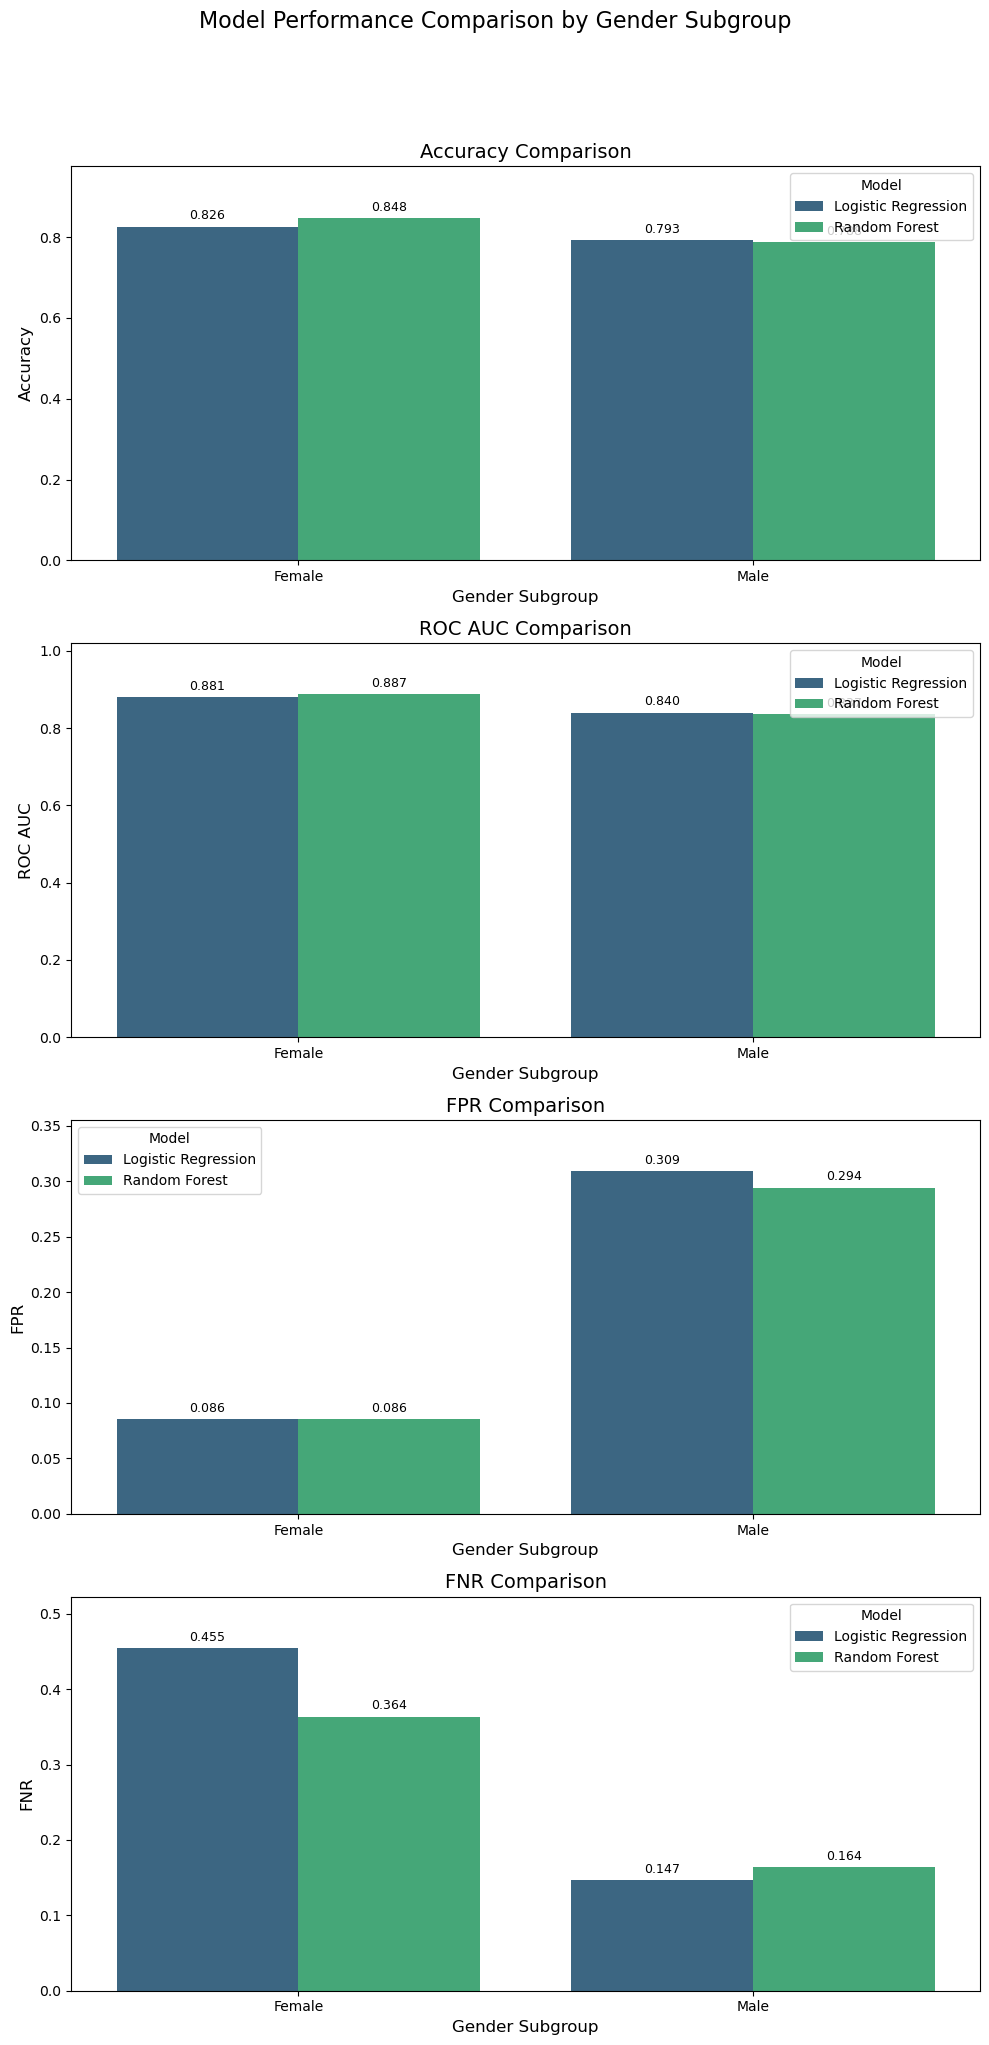


--- Bias Analysis (Subgroup Performance for Gender) - Visualizations Finished ---


In [41]:
# Bias Analysis (Subgroup Performance for Gender) - Visualizations
# This cell assumes 'bias_performance_df' is available from Cell 18.
# It also assumes matplotlib and seaborn are imported.

print("\n---  Bias Analysis (Subgroup Performance for Gender) - Visualizations ---")

if 'bias_performance_df' in locals() and not bias_performance_df.empty:
    # --- 6. Visualize Bias Metrics ---
    metrics_to_plot = ['Accuracy', 'ROC AUC', 'FPR', 'FNR']
    # Filter out metrics that might be all NaN if subgroups were too small or problematic
    plottable_metrics = [m for m in metrics_to_plot if m in bias_performance_df.columns and not bias_performance_df[m].isnull().all()]
    
    num_metrics_to_plot = len(plottable_metrics)

    if num_metrics_to_plot > 0:
        fig, axes = plt.subplots(num_metrics_to_plot, 1, figsize=(10, 5 * num_metrics_to_plot), sharex=False)
        if num_metrics_to_plot == 1: # Make axes iterable if only one metric
            axes = [axes] 

        fig.suptitle('Model Performance Comparison by Gender Subgroup', fontsize=16, y=1.02)

        for i, metric in enumerate(plottable_metrics):
            # Create the barplot
            sns.barplot(data=bias_performance_df, x='Subgroup', y=metric, hue='Model', ax=axes[i], palette='viridis')
            axes[i].set_title(f'{metric} Comparison', fontsize=14)
            axes[i].set_xlabel('Gender Subgroup', fontsize=12)
            axes[i].set_ylabel(metric, fontsize=12)
            axes[i].legend(title='Model', loc='best', fontsize=10)
            axes[i].tick_params(axis='x', labelsize=10)
            axes[i].tick_params(axis='y', labelsize=10)
            
            # Add annotations to bars
            for container in axes[i].containers:
                try:
                    axes[i].bar_label(container, fmt='%.3f', fontsize=9, padding=3)
                except AttributeError: # Fallback for older matplotlib
                     for p in container.patches:
                        if p.get_height() != 0 and pd.notna(p.get_height()): # only annotate non-zero and non-NaN bars
                            axes[i].annotate(f'{p.get_height():.3f}', 
                                             (p.get_x() + p.get_width() / 2., p.get_height()), 
                                             ha='center', va='center', 
                                             xytext=(0, 5), 
                                             textcoords='offset points', fontsize=9)

            axes[i].margins(y=0.15) # Add some margin for labels to fit

        plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout for suptitle
        plt.show()
    else:
        print("\nCannot generate bias metric plots: No plottable metrics found in 'bias_performance_df'.")
else:
    print("\nCannot generate bias metric plots: 'bias_performance_df' is not available or is empty.")
    print("Please ensure Cell 18 (Bias Analysis Calculations) ran successfully.")

print("\n--- Bias Analysis (Subgroup Performance for Gender) - Visualizations Finished ---")


In [42]:
#  Fairness Analysis (Demographic Parity & Equal Opportunity for Gender) - Calculations
# This cell assumes variables  (X_test), (y_pred_log_reg, y_pred_rand_forest),
# and  (y_test_series, X_test_original_sensitive_attr, SENSITIVE_ATTRIBUTE) are available.
# It also assumes pandas, numpy, and warnings are imported.

print("\n--- Fairness Analysis (Demographic Parity & Equal Opportunity for Gender) - Calculations ---")

# --- Define Positive Class Label ---
POSITIVE_CLASS_LABEL = 1 # Heart disease is present

# --- 0. Verify Data Availability ---
required_vars_chunk4_calc = True
vars_to_check_chunk4_calc = [
    'X_test_original_sensitive_attr', 'y_test_series', 
    'y_pred_log_reg', 'y_pred_rand_forest', 'SENSITIVE_ATTRIBUTE'
]
for var_name in vars_to_check_chunk4_calc:
    if var_name not in locals():
        print(f"Error: Essential variable '{var_name}' from previous Chunks not found for Chunk 4 Calculations.")
        required_vars_chunk4_calc = False

# Initialize y_prob arrays as they are not directly used here but checked in stand-in
if 'y_prob_log_reg' not in locals(): y_prob_log_reg = np.array([])
if 'y_prob_rand_forest' not in locals(): y_prob_rand_forest = np.array([])


if not required_vars_chunk4_calc:
    print("Cannot proceed with Fairness Analysis (DP & EOpp) Calculations due to missing variables.")
    # Create dummy stand-ins for script to be syntactically valid if run in isolation (NOT FOR ANALYSIS)
    _n_test_samples_c4 = 75
    SENSITIVE_ATTRIBUTE = 'sex' # Ensure this is defined
    X_test_original_sensitive_attr = pd.DataFrame({SENSITIVE_ATTRIBUTE: np.random.randint(0, 2, _n_test_samples_c4)}, index=range(_n_test_samples_c4))
    y_test_series = pd.Series(np.random.randint(0, 2, _n_test_samples_c4), index=X_test_original_sensitive_attr.index)
    y_pred_log_reg = np.random.randint(0, 2, _n_test_samples_c4)
    y_pred_rand_forest = np.random.randint(0, 2, _n_test_samples_c4)
    print("Using minimal DUMMY data for Chunk 4 Calculations demonstration.")
else:
    print("Using variables from previous chunks for Fairness Analysis (DP & EOpp) Calculations.")


# --- 1. Helper Function to Calculate Fairness Metrics ---
def calculate_fairness_metrics_dp_eopp(y_true_full, y_pred_labels_full, group_mask, subgroup_name, model_name):
    """Calculates Demographic Parity and Equal Opportunity metrics for a subgroup."""
    
    # Ensure y_pred_labels_full is a numpy array for direct boolean indexing with group_mask.values
    if isinstance(y_pred_labels_full, pd.Series):
        y_pred_labels_full = y_pred_labels_full.values

    y_true_sub = y_true_full[group_mask]
    y_pred_labels_sub = y_pred_labels_full[group_mask.values] # Use .values for numpy boolean array indexing
    
    num_samples = len(y_true_sub)

    if num_samples == 0:
        print(f"Info: No samples for {subgroup_name} ({model_name}). Skipping fairness metrics calculation.")
        return None

    # Demographic Parity (Positive Prediction Rate): P(Y_hat = 1 | Group)
    positive_prediction_rate = np.mean(y_pred_labels_sub == POSITIVE_CLASS_LABEL)

    # Equal Opportunity (True Positive Rate): P(Y_hat = 1 | Y = 1, Group)
    # Filter true labels for actual positives within the subgroup
    actual_positives_in_subgroup_mask = (y_true_sub == POSITIVE_CLASS_LABEL)
    num_actual_positives_sub = actual_positives_in_subgroup_mask.sum()

    if num_actual_positives_sub == 0:
        true_positive_rate = np.nan 
        # print(f"Warning: No actual positive samples found for {subgroup_name} ({model_name}). Equal Opportunity (TPR) is N/A.")
    else:
        # Predictions for the actual positive samples in the subgroup
        y_pred_for_actual_positives_sub = y_pred_labels_sub[actual_positives_in_subgroup_mask]
        true_positive_rate = np.mean(y_pred_for_actual_positives_sub == POSITIVE_CLASS_LABEL)

    print(f"\n--- Fairness Metrics: {model_name} for {subgroup_name} ---")
    print(f"Samples in group: {num_samples}")
    print(f"Positive Prediction Rate (Demographic Parity): {positive_prediction_rate:.4f}")
    print(f"True Positive Rate (Equal Opportunity): {true_positive_rate:.4f}" if not pd.isna(true_positive_rate) else "True Positive Rate (Equal Opportunity): N/A")

    return {
        'Subgroup': subgroup_name,
        'Model': model_name,
        'Samples': num_samples,
        'Positive Prediction Rate (DP)': positive_prediction_rate,
        'True Positive Rate (EOpp)': true_positive_rate
    }

# --- 2. Calculate Fairness Metrics for Each Subgroup and Model ---
fairness_results_gender_dp_eopp = []
gender_groups_map = {0: 'Female', 1: 'Male'} # From our 'sex' encoding

# Ensure X_test_original_sensitive_attr is not empty and SENSITIVE_ATTRIBUTE exists
if 'X_test_original_sensitive_attr' in locals() and not X_test_original_sensitive_attr.empty and SENSITIVE_ATTRIBUTE in X_test_original_sensitive_attr.columns:
    unique_genders_in_test = sorted(X_test_original_sensitive_attr[SENSITIVE_ATTRIBUTE].unique())
    print(f"\nGender groups found in test set for DP/EOpp analysis: {[gender_groups_map.get(g, g) for g in unique_genders_in_test]}")

    # --- Logistic Regression ---
    if 'y_pred_log_reg' in locals() and y_pred_log_reg.size > 0:
        print("\n" + "="*30 + "\nFairness Analysis (DP & EOpp) by Gender: Logistic Regression\n" + "="*30)
        for gender_code in unique_genders_in_test:
            gender_label = gender_groups_map.get(gender_code, f"Group_{gender_code}")
            mask = (X_test_original_sensitive_attr[SENSITIVE_ATTRIBUTE] == gender_code)
            if mask.sum() > 0 : # Ensure subgroup is not empty
                 metrics = calculate_fairness_metrics_dp_eopp(y_test_series, y_pred_log_reg, mask, gender_label, 'Logistic Regression')
                 if metrics: fairness_results_gender_dp_eopp.append(metrics)
            else:
                print(f"Skipping {gender_label} for Logistic Regression: No samples in this subgroup.")
    else:
        print("\nSkipping Logistic Regression DP/EOpp calculation: Predictions not available.")


    # --- Random Forest ---
    if 'y_pred_rand_forest' in locals() and y_pred_rand_forest.size > 0:
        print("\n" + "="*30 + "\nFairness Analysis (DP & EOpp) by Gender: Random Forest\n" + "="*30)
        for gender_code in unique_genders_in_test:
            gender_label = gender_groups_map.get(gender_code, f"Group_{gender_code}")
            mask = (X_test_original_sensitive_attr[SENSITIVE_ATTRIBUTE] == gender_code)
            if mask.sum() > 0: # Ensure subgroup is not empty
                metrics = calculate_fairness_metrics_dp_eopp(y_test_series, y_pred_rand_forest, mask, gender_label, 'Random Forest')
                if metrics: fairness_results_gender_dp_eopp.append(metrics)
            else:
                print(f"Skipping {gender_label} for Random Forest: No samples in this subgroup.")
    else:
        print("\nSkipping Random Forest DP/EOpp calculation: Predictions not available.")
else:
    print("\nSkipping DP/EOpp calculation: Sensitive attribute data ('X_test_original_sensitive_attr') is missing or empty.")


# --- 3. Compile, Display, and Analyze Disparities ---
if fairness_results_gender_dp_eopp:
    fairness_gender_df_dp_eopp = pd.DataFrame(fairness_results_gender_dp_eopp)
    fairness_gender_df_dp_eopp.sort_values(by=['Model', 'Subgroup'], inplace=True)

    print("\n\n--- Summary of Fairness Analysis by Gender (Demographic Parity & Equal Opportunity) ---")
    # Format float columns for printing
    for col in ['Positive Prediction Rate (DP)', 'True Positive Rate (EOpp)']:
        if col in fairness_gender_df_dp_eopp.columns:
            fairness_gender_df_dp_eopp[col] = pd.to_numeric(fairness_gender_df_dp_eopp[col], errors='coerce')
    print(fairness_gender_df_dp_eopp.to_string(float_format=lambda x: f'{x:.4f}' if pd.notnull(x) else 'N/A'))


    print("\n--- Fairness Disparities (Male Rate - Female Rate) ---")
    for model_name in fairness_gender_df_dp_eopp['Model'].unique():
        model_df = fairness_gender_df_dp_eopp[fairness_gender_df_dp_eopp['Model'] == model_name].set_index('Subgroup')
        if 'Female' in model_df.index and 'Male' in model_df.index:
            dp_female = model_df.loc['Female', 'Positive Prediction Rate (DP)']
            dp_male = model_df.loc['Male', 'Positive Prediction Rate (DP)']
            dp_disparity = dp_male - dp_female

            eopp_female = model_df.loc['Female', 'True Positive Rate (EOpp)']
            eopp_male = model_df.loc['Male', 'True Positive Rate (EOpp)']
            eopp_disparity = (eopp_male - eopp_female) if not (pd.isna(eopp_male) or pd.isna(eopp_female)) else np.nan

            print(f"\n{model_name}:")
            print(f"  Demographic Parity Disparity (Male - Female PPR): {dp_disparity:+.4f}")
            if not pd.isna(eopp_disparity):
                print(f"  Equal Opportunity Disparity (Male - Female TPR): {eopp_disparity:+.4f}")
            else:
                print(f"  Equal Opportunity Disparity (Male - Female TPR): N/A (TPR for one or both groups was N/A or calculation error)")
        else:
            print(f"\n{model_name}: Could not calculate disparities (Female or Male group missing from results or had no samples).")
else:
    print("\nNo fairness results (DP & EOpp) generated, likely due to empty subgroups or errors.")
    fairness_gender_df_dp_eopp = pd.DataFrame() # Ensure it exists as an empty DataFrame

print("\n---  Fairness Analysis (Demographic Parity & Equal Opportunity for Gender) - Calculations Finished ---")
# Key output: fairness_gender_df_dp_eopp (DataFrame with DP and EOpp metrics)
# This DataFrame will be used in the next cell for visualization.



--- Fairness Analysis (Demographic Parity & Equal Opportunity for Gender) - Calculations ---
Using variables from previous chunks for Fairness Analysis (DP & EOpp) Calculations.

Gender groups found in test set for DP/EOpp analysis: ['Female', 'Male']

Fairness Analysis (DP & EOpp) by Gender: Logistic Regression

--- Fairness Metrics: Logistic Regression for Female ---
Samples in group: 46
Positive Prediction Rate (Demographic Parity): 0.1957
True Positive Rate (Equal Opportunity): 0.5455

--- Fairness Metrics: Logistic Regression for Male ---
Samples in group: 184
Positive Prediction Rate (Demographic Parity): 0.6522
True Positive Rate (Equal Opportunity): 0.8534

Fairness Analysis (DP & EOpp) by Gender: Random Forest

--- Fairness Metrics: Random Forest for Female ---
Samples in group: 46
Positive Prediction Rate (Demographic Parity): 0.2174
True Positive Rate (Equal Opportunity): 0.6364

--- Fairness Metrics: Random Forest for Male ---
Samples in group: 184
Positive Prediction Rate


---  Fairness Analysis (Demographic Parity & Equal Opportunity for Gender) - Visualizations ---


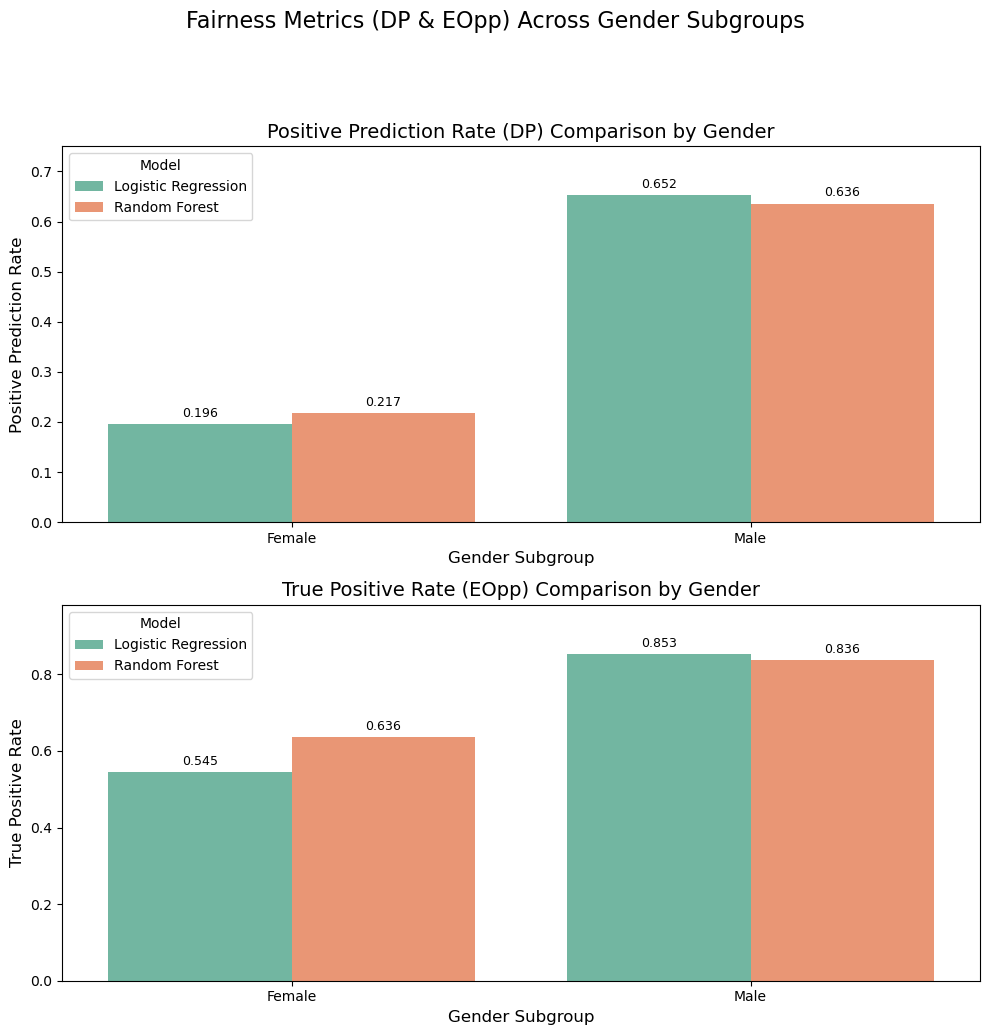


---  Fairness Analysis (Demographic Parity & Equal Opportunity for Gender) - Visualizations Finished ---


In [43]:
#  Fairness Analysis (Demographic Parity & Equal Opportunity for Gender) - Visualizations
# This cell assumes 'fairness_gender_df_dp_eopp' is available from Cell 20.
# It also assumes matplotlib and seaborn are imported.

print("\n---  Fairness Analysis (Demographic Parity & Equal Opportunity for Gender) - Visualizations ---")

if 'fairness_gender_df_dp_eopp' in locals() and not fairness_gender_df_dp_eopp.empty:
    fairness_metrics_to_plot_dp_eopp = ['Positive Prediction Rate (DP)', 'True Positive Rate (EOpp)']
    # Filter out metrics that might be all NaN
    plottable_fairness_metrics = [
        m for m in fairness_metrics_to_plot_dp_eopp 
        if m in fairness_gender_df_dp_eopp.columns and not fairness_gender_df_dp_eopp[m].isnull().all()
    ]
    
    num_fairness_metrics_plot = len(plottable_fairness_metrics)

    if num_fairness_metrics_plot > 0:
        fig_fairness, axes_fairness = plt.subplots(num_fairness_metrics_plot, 1, figsize=(10, 5 * num_fairness_metrics_plot), sharex=False)
        if num_fairness_metrics_plot == 1: # Make axes iterable if only one metric
            axes_fairness = [axes_fairness] 

        fig_fairness.suptitle('Fairness Metrics (DP & EOpp) Across Gender Subgroups', fontsize=16, y=1.03)

        for i, metric in enumerate(plottable_fairness_metrics):
            ax = axes_fairness[i]
            # Further filter out rows where the current metric is NaN for plotting
            current_metric_plot_df = fairness_gender_df_dp_eopp.dropna(subset=[metric])

            if not current_metric_plot_df.empty:
                sns.barplot(data=current_metric_plot_df, x='Subgroup', y=metric, hue='Model', ax=ax, palette='Set2')
                ax.set_title(f'{metric} Comparison by Gender', fontsize=14)
                ax.set_xlabel('Gender Subgroup', fontsize=12)
                ax.set_ylabel(metric.split('(')[0].strip(), fontsize=12) # Cleaner label
                ax.legend(title='Model', loc='best', fontsize=10)
                ax.tick_params(axis='x', rotation=0, labelsize=10)
                ax.tick_params(axis='y', labelsize=10)

                # Add annotations to bars
                for container in ax.containers:
                    labels = [f'{val:.3f}' if pd.notna(val) else 'N/A' for val in container.datavalues]
                    try:
                        ax.bar_label(container, labels=labels, label_type='edge', fontsize=9, padding=3)
                    except AttributeError: # Fallback for older matplotlib
                        for j, p in enumerate(container.patches):
                             if pd.notna(p.get_height()) and p.get_height() !=0:
                                ax.annotate(labels[j],
                                            (p.get_x() + p.get_width() / 2., p.get_height()),
                                            ha='center', va='center',
                                            xytext=(0, 5),
                                            textcoords='offset points', fontsize=9)
                ax.margins(y=0.15) # Add margin for labels
            else:
                ax.text(0.5, 0.5, f"No data to plot for {metric}\n(all values might be NaN or subgroup empty)", 
                        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                ax.set_title(f'{metric} Comparison by Gender (No Data)', fontsize=14)
                ax.set_xlabel('Gender Subgroup', fontsize=12)
                ax.set_ylabel(metric.split('(')[0].strip(), fontsize=12)


        plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout for suptitle
        plt.show()
    else:
        print("\nCannot generate fairness metric plots (DP & EOpp): No plottable metrics found in 'fairness_gender_df_dp_eopp'.")
else:
    print("\nCannot generate fairness metric plots (DP & EOpp): 'fairness_gender_df_dp_eopp' is not available or is empty.")
    print("Please ensure  (Fairness Analysis Calculations - DP & EOpp) ran successfully.")

print("\n---  Fairness Analysis (Demographic Parity & Equal Opportunity for Gender) - Visualizations Finished ---")
# </cell>


"""
## Interpretation of Fairness Results

This section is dedicated to interpreting the fairness analysis results obtained from the previous cells (Cells 18-21), focusing on gender as the sensitive attribute.

### Summary of Observations:

1.  **Performance Metrics (Cell 18 & 19 - `bias_performance_df`):**
    * Review the Accuracy, ROC AUC, False Positive Rate (FPR), and False Negative Rate (FNR) for both 'Female' and 'Male' subgroups across the Logistic Regression and Random Forest models.
    * **Key Questions to Address:**
        * Are there significant differences in accuracy or ROC AUC between genders for either model?
        * Does one model exhibit larger disparities in performance metrics (FPR, FNR) between genders compared to the other?
        * **FPR Disparity:** A higher FPR for one group means that individuals from that group are more likely to be incorrectly classified as having heart disease when they don't. Note any significant differences.
        * **FNR Disparity:** A higher FNR for one group means that individuals from that group are more likely to be incorrectly classified as *not* having heart disease when they actually do (a potentially more harmful error in a medical context). Note any significant differences.
        * Consider the sample sizes for each subgroup. Small sample sizes can lead to less reliable metric estimates.

2.  **Fairness Metrics (Cell 20 & 21 - `fairness_gender_df_dp_eopp`):**
    * **Demographic Parity (Positive Prediction Rate - PPR):**
        * This metric measures whether the probability of being predicted positive (diagnosed with heart disease) is similar across gender groups: $P(\hat{Y}=1 | \text{sex}=\text{female}) \approx P(\hat{Y}=1 | \text{sex}=\text{male})$.
        * Examine the 'Positive Prediction Rate (DP)' values for 'Female' and 'Male' for both models.
        * Calculate or observe the disparity (difference or ratio). A large disparity suggests that one gender is significantly more likely to be predicted as having heart disease, regardless of their true condition.
    * **Equal Opportunity (True Positive Rate - TPR):**
        * This metric measures whether the probability of a true positive (correctly diagnosed with heart disease when actually having it) is similar across gender groups: $P(\hat{Y}=1 | Y=1, \text{sex}=\text{female}) \approx P(\hat{Y}=1 | Y=1, \text{sex}=\text{male})$.
        * Examine the 'True Positive Rate (EOpp)' values. This is equivalent to sensitivity or recall for the positive class within each group.
        * Calculate or observe the disparity. A large disparity here means that individuals from one gender who actually have heart disease are more (or less) likely to be correctly identified by the model compared to the other gender. This is often a critical fairness metric in medical applications.
        * Note if TPR is N/A for any group, which would happen if there were no actual positive samples for that group in the test set.

### Potential Implications and Next Steps:

* **Observed Biases:** Based on the disparities, articulate which model (if any) appears to be more biased and with respect to which metrics (performance, DP, EOpp).
* **Contextual Harm:** Discuss the potential real-world implications of these biases. For example, a higher FNR for one gender could lead to under-diagnosis and delayed treatment. A higher FPR could lead to unnecessary stress and follow-up procedures.
* **Further Investigation:**
    * Could data imbalances (e.g., significantly fewer samples for one gender, or different prevalence of heart disease in the training data for each gender) be contributing?
    * Are there specific features in the model that might be acting as proxies for gender or interacting with gender in a way that introduces bias?
* **Mitigation Strategies (to be explored in subsequent cells):**
    * **Pre-processing:** Techniques like re-sampling (oversampling the minority group, undersampling the majority) or re-weighting training samples.
    * **In-processing:** Modifying the learning algorithm to incorporate fairness constraints (e.g., using algorithms from libraries like Fairlearn).
    * **Post-processing:** Adjusting prediction thresholds differently for each subgroup to achieve better parity in outcomes (e.g., to equalize FPR or TPR).

**Fill in your specific observations based on the output of your notebook runs in the sections above.**
For example:
* *"The Random Forest model showed a 10% higher FNR for the Female subgroup compared to the Male subgroup, suggesting that females with heart disease are more likely to be missed by this model."*
* *"Logistic Regression exhibited a Demographic Parity disparity of 0.15 (PPR_male - PPR_female), indicating males were more frequently predicted positive."*

This structured interpretation will help in understanding the extent and nature of any biases present and guide potential mitigation efforts.
"""

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression # For the base estimator
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds # Import necessary Fairlearn components

import warnings
warnings.filterwarnings('ignore')

# --- Assume variables from previous Chunks are available: ---
# Chunk 1: X_train, X_test, y_train, y_test (original splits before ColumnTransformer)
#          X_train_processed, X_test_processed (NumPy arrays after ColumnTransformer)
#          SENSITIVE_ATTRIBUTE (string, e.g., 'sex')
# Chunk 2: log_reg, rand_forest (trained unmitigated models)
#          y_pred_log_reg, y_prob_log_reg
#          y_pred_rand_forest, y_prob_rand_forest
# Chunk 3: evaluate_subgroup_performance (helper function)
#          bias_performance_df (DataFrame with metrics for unmitigated LR and RF)
#          X_test_original_sensitive_attr (DataFrame with 'sex' for test set)
#          y_test_series (pandas Series of true labels for test set)
# Chunk 4: calculate_fairness_metrics_dp_eopp (helper function)
#          fairness_gender_df_dp_eopp (DataFrame with DP & EOpp for unmitigated LR and RF)


# --- Placeholder for helper functions if not in global scope (should be defined in previous cells) ---
if 'evaluate_subgroup_performance' not in locals():
    print("Defining dummy 'evaluate_subgroup_performance' function. Ensure the real one is loaded.")
    def evaluate_subgroup_performance(y_true_full, y_pred_full, y_prob_full, subgroup_mask, subgroup_name, model_name):
        # This is a placeholder. The actual function from Chunk 3 is needed for meaningful results.
        print(f"DUMMY: Evaluating {model_name} for {subgroup_name}")
        if subgroup_mask.sum() == 0: return None
        return {'Subgroup': subgroup_name, 'Model': model_name, 'Accuracy': 0.5, 'ROC AUC': 0.5, 'FPR': 0.5, 'FNR': 0.5, 'Samples': subgroup_mask.sum()}

if 'calculate_fairness_metrics_dp_eopp' not in locals():
    print("Defining dummy 'calculate_fairness_metrics_dp_eopp' function. Ensure the real one is loaded.")
    def calculate_fairness_metrics_dp_eopp(y_true_full, y_pred_labels_full, group_mask, subgroup_name, model_name):
        # This is a placeholder. The actual function from Chunk 4 is needed.
        print(f"DUMMY: Calculating DP/EOpp for {model_name} for {subgroup_name}")
        if group_mask.sum() == 0: return None
        return {'Subgroup': subgroup_name, 'Model': model_name, 'Samples': group_mask.sum(), 'Positive Prediction Rate (DP)': 0.5, 'True Positive Rate (EOpp)': 0.5}
# --- End Placeholder ---


# --- Verification of Previous Chunk Variables ---
essential_vars = ['X_train_processed', 'y_train', 'X_train', 'SENSITIVE_ATTRIBUTE',
                  'X_test_processed', 'y_test_series', 'X_test_original_sensitive_attr']
optional_dfs_for_comparison = ['bias_performance_df', 'fairness_gender_df_dp_eopp']

# **Correction: Define SENSITIVE_ATTRIBUTE with a default before the loop if it might not exist.**
if 'SENSITIVE_ATTRIBUTE' not in locals():
    print("Warning: 'SENSITIVE_ATTRIBUTE' not found globally. Defaulting to 'sex' for placeholder creation.")
    SENSITIVE_ATTRIBUTE = 'sex'


for var in essential_vars:
    if var not in locals():
        print(f"Error: Essential variable '{var}' from previous chunks not found. Please run them first.")
        print("This chunk requires these variables to function correctly.")
        # As a fallback for independent execution, define minimal placeholders
        # This section should ideally be removed if running sequentially in a notebook.
        if var == 'SENSITIVE_ATTRIBUTE' and 'SENSITIVE_ATTRIBUTE' not in locals(): # Already handled above, but as a safeguard
            SENSITIVE_ATTRIBUTE = 'sex'
        elif var == 'X_train_processed': X_train_processed = np.random.rand(225, 10)
        elif var == 'y_train': y_train = pd.Series(np.random.randint(0, 2, 225))
        elif var == 'X_train': X_train = pd.DataFrame({SENSITIVE_ATTRIBUTE: np.random.randint(0, 2, 225), 'age': np.random.rand(225)})
        elif var == 'X_test_processed': X_test_processed = np.random.rand(75, 10)
        elif var == 'y_test_series': y_test_series = pd.Series(np.random.randint(0, 2, 75))
        elif var == 'X_test_original_sensitive_attr': X_test_original_sensitive_attr = pd.DataFrame({SENSITIVE_ATTRIBUTE: np.random.randint(0, 2, 75)})

for df_name in optional_dfs_for_comparison:
    if df_name not in locals():
        print(f"Warning: DataFrame '{df_name}' for comparison not found. Comparisons might be incomplete.")
        if df_name == 'bias_performance_df':
            bias_performance_df = pd.DataFrame(columns=['Subgroup', 'Model', 'Accuracy', 'ROC AUC', 'FPR', 'FNR', 'Samples'])
        elif df_name == 'fairness_gender_df_dp_eopp':
            fairness_gender_df_dp_eopp = pd.DataFrame(columns=['Subgroup', 'Model', 'Samples', 'Positive Prediction Rate (DP)', 'True Positive Rate (EOpp)'])

if 'POSITIVE_CLASS_LABEL' not in locals():
    POSITIVE_CLASS_LABEL = 1 # Default if not defined in Chunk 4
    print(f"INFO: POSITIVE_CLASS_LABEL not found, defaulting to {POSITIVE_CLASS_LABEL}")


print("\n--- Chunk 5: Bias Mitigation with ExponentiatedGradient ---")
print("\n--- Step 5.1: Setting up ExponentiatedGradient ---")

# Define the base estimator
base_estimator = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')

# Define the fairness constraint
# DemographicParity() aims for equal selection rates across groups.
# EqualizedOdds() aims for equal TPR and FPR across groups.
constraint = DemographicParity()
# constraint = EqualizedOdds() # Alternative constraint to try

mitigator = ExponentiatedGradient(
    estimator=base_estimator,
    constraints=constraint,
    eps=0.01  # Allowed fairness constraint violation (trade-off parameter)
)
print(f"Mitigator: ExponentiatedGradient with estimator {base_estimator.__class__.__name__} and constraint {constraint.__class__.__name__}")


--- Chunk 5: Bias Mitigation with ExponentiatedGradient ---

--- Step 5.1: Setting up ExponentiatedGradient ---
Mitigator: ExponentiatedGradient with estimator LogisticRegression and constraint DemographicParity


In [71]:
print("\n--- Step 5.2: Training the Mitigated Model ---")
# ExponentiatedGradient's fit method requires X, y, and sensitive_features
# X_train_processed is our preprocessed feature set
# y_train is our target variable
# X_train[SENSITIVE_ATTRIBUTE] provides the sensitive feature from the *original* (non-preprocessed) training data

mitigator_trained = False
if 'mitigator' in locals() and \
   'X_train_processed' in locals() and X_train_processed.size > 0 and \
   'y_train' in locals() and y_train.size > 0 and \
   'X_train' in locals() and not X_train.empty and SENSITIVE_ATTRIBUTE in X_train.columns:
    try:
        mitigator.fit(X_train_processed, y_train, sensitive_features=X_train[SENSITIVE_ATTRIBUTE])
        print("ExponentiatedGradient model trained successfully.")
        mitigator_trained = True
    except Exception as e:
        print(f"An error occurred during ExponentiatedGradient training: {e}")
        mitigator = None # Ensure mitigator is None if training fails
else:
    print("Skipping ExponentiatedGradient training due to missing prerequisite variables or empty data.")
    mitigator = None # Ensure mitigator is None if prerequisites are missing


--- Step 5.2: Training the Mitigated Model ---
ExponentiatedGradient model trained successfully.


In [73]:
y_pred_mitigated = None
y_prob_mitigated = None

if mitigator_trained and mitigator is not None:
    print("\n--- Step 5.3: Making Predictions with Mitigated Model ---")
    if 'X_test_processed' in locals() and X_test_processed.size > 0:
        y_pred_mitigated = mitigator.predict(X_test_processed)
        
        try:
            y_prob_mitigated = mitigator.predict_proba(X_test_processed)[:, 1]
            print("Probabilities obtained from mitigated model.")
        except AttributeError:
            print("Warning: Mitigated model from ExponentiatedGradient does not have a direct predict_proba method.")
            if hasattr(mitigator, "decision_function"):
                y_scores_mitigated = mitigator.decision_function(X_test_processed)
                y_prob_mitigated = (y_scores_mitigated - y_scores_mitigated.min()) / (y_scores_mitigated.max() - y_scores_mitigated.min()) # Simple scaling
                print("Used scaled decision_function output for y_prob_mitigated.")
            else:
                y_prob_mitigated = y_pred_mitigated # Fallback for AUC, won't be a good AUC
                print("Using y_pred_mitigated for y_prob_mitigated as predict_proba/decision_function failed.")
        print("Predictions made with mitigated model.")
    else:
        print("Skipping predictions as X_test_processed is empty or not available.")
else:
    print("Skipping predictions as mitigated model training failed or mitigator is not defined.")


--- Step 5.3: Making Predictions with Mitigated Model ---
Using y_pred_mitigated for y_prob_mitigated as predict_proba/decision_function failed.
Predictions made with mitigated model.


In [75]:
roc_auc_mitigated = np.nan # Initialize

if y_pred_mitigated is not None and y_prob_mitigated is not None and 'y_test_series' in locals() and y_test_series.size > 0:
    print("\n--- Step 5.4: Overall Evaluation: Mitigated Model (ExponentiatedGradient) ---")
    print(f"Accuracy: {accuracy_score(y_test_series, y_pred_mitigated):.4f}")
    
    if len(np.unique(y_test_series)) > 1:
        try:
            roc_auc_mitigated = roc_auc_score(y_test_series, y_prob_mitigated)
            print(f"ROC AUC: {roc_auc_mitigated:.4f}")
        except ValueError as e_auc:
            print(f"ROC AUC could not be calculated: {e_auc}. Ensure y_prob_mitigated are valid probabilities or scores.")
    else:
        print("ROC AUC: Not applicable (single class in y_test_series or probabilities not available).")
        
    print("Classification Report:\n", classification_report(y_test_series, y_pred_mitigated, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test_series, y_pred_mitigated))
else:
    print("\nSkipping overall evaluation of mitigated model: Predictions or y_test_series not available.")


--- Step 5.4: Overall Evaluation: Mitigated Model (ExponentiatedGradient) ---
Accuracy: 0.7522
ROC AUC: 0.7453
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.68      0.71       103
           1       0.76      0.81      0.78       127

    accuracy                           0.75       230
   macro avg       0.75      0.75      0.75       230
weighted avg       0.75      0.75      0.75       230

Confusion Matrix:
 [[ 70  33]
 [ 24 103]]


In [77]:
mitigated_model_bias_metrics_list = []
mitigated_model_fairness_dp_eopp_list = []

if (y_pred_mitigated is not None and y_prob_mitigated is not None and
    'X_test_original_sensitive_attr' in locals() and not X_test_original_sensitive_attr.empty and
    SENSITIVE_ATTRIBUTE in X_test_original_sensitive_attr.columns and
    'y_test_series' in locals() and not y_test_series.empty):

    print("\n" + "="*30 + "\nBias & Fairness Analysis: Mitigated Model (ExponentiatedGradient)\n" + "="*30)
    
    female_mask_mitigated = (X_test_original_sensitive_attr[SENSITIVE_ATTRIBUTE] == 0)
    male_mask_mitigated = (X_test_original_sensitive_attr[SENSITIVE_ATTRIBUTE] == 1)
    
    # Subgroup Performance (Accuracy, ROC AUC, FPR, FNR)
    print("\n--- Subgroup Performance (Bias Metrics) ---")
    if female_mask_mitigated.sum() > 0:
        eg_female_perf = evaluate_subgroup_performance(y_test_series, y_pred_mitigated, y_prob_mitigated, female_mask_mitigated, 'Female', 'ExpGradient')
        if eg_female_perf: mitigated_model_bias_metrics_list.append(eg_female_perf)
    else:
        print("Skipping Female subgroup performance: No samples in this group.")

    if male_mask_mitigated.sum() > 0:
        eg_male_perf = evaluate_subgroup_performance(y_test_series, y_pred_mitigated, y_prob_mitigated, male_mask_mitigated, 'Male', 'ExpGradient')
        if eg_male_perf: mitigated_model_bias_metrics_list.append(eg_male_perf)
    else:
        print("Skipping Male subgroup performance: No samples in this group.")

    # Fairness Metrics (DP & EOpp)
    print("\n--- Fairness Metrics (DP & EOpp) ---")
    if female_mask_mitigated.sum() > 0:
        eg_female_fair = calculate_fairness_metrics_dp_eopp(y_test_series, y_pred_mitigated, female_mask_mitigated, 'Female', 'ExpGradient')
        if eg_female_fair: mitigated_model_fairness_dp_eopp_list.append(eg_female_fair)
    else:
        print("Skipping Female subgroup fairness: No samples in this group.")
        
    if male_mask_mitigated.sum() > 0:
        eg_male_fair = calculate_fairness_metrics_dp_eopp(y_test_series, y_pred_mitigated, male_mask_mitigated, 'Male', 'ExpGradient')
        if eg_male_fair: mitigated_model_fairness_dp_eopp_list.append(eg_male_fair)
    else:
        print("Skipping Male subgroup fairness: No samples in this group.")
else:
    print("\nSkipping subgroup performance and fairness metrics for mitigated model: Predictions or necessary data not available.")

mitigated_bias_perf_df = pd.DataFrame(mitigated_model_bias_metrics_list)
mitigated_fairness_dp_eopp_df = pd.DataFrame(mitigated_model_fairness_dp_eopp_list)

if not mitigated_bias_perf_df.empty:
    print("\nMitigated Model Bias Performance DataFrame:")
    print(mitigated_bias_perf_df.to_string())
if not mitigated_fairness_dp_eopp_df.empty:
    print("\nMitigated Model Fairness (DP & EOpp) DataFrame:")
    print(mitigated_fairness_dp_eopp_df.to_string())


Bias & Fairness Analysis: Mitigated Model (ExponentiatedGradient)

--- Subgroup Performance (Bias Metrics) ---

--- ExpGradient Evaluation for Female ---
Test Samples: 46
Accuracy: 0.6739
ROC AUC: 0.7857
FPR (Type I Error - Predict disease when absent): 0.4286
FNR (Type II Error - Predict no disease when present): 0.0000

--- ExpGradient Evaluation for Male ---
Test Samples: 184
Accuracy: 0.7717
ROC AUC: 0.7642
FPR (Type I Error - Predict disease when absent): 0.2647
FNR (Type II Error - Predict no disease when present): 0.2069

--- Fairness Metrics (DP & EOpp) ---

--- Fairness Metrics: ExpGradient for Female ---
Samples in group: 46
Positive Prediction Rate (Demographic Parity): 0.5652
True Positive Rate (Equal Opportunity): 1.0000

--- Fairness Metrics: ExpGradient for Male ---
Samples in group: 184
Positive Prediction Rate (Demographic Parity): 0.5978
True Positive Rate (Equal Opportunity): 0.7931

Mitigated Model Bias Performance DataFrame:
  Subgroup        Model  Accuracy   ROC


--- Step 5.7: Comparing Mitigated Model with Unmitigated Models (Performance Metrics) ---


--- Combined Summary of Subgroup Performance (Accuracy, ROC AUC, FPR, FNR) ---
  Subgroup                Model  Accuracy   ROC AUC       FPR       FNR  Samples
0   Female  Logistic Regression  0.826087  0.880519  0.085714  0.454545       46
1     Male  Logistic Regression  0.793478  0.840137  0.308824  0.146552      184
2   Female        Random Forest  0.847826  0.887013  0.085714  0.363636       46
3     Male        Random Forest  0.788043  0.836714  0.294118  0.163793      184
4   Female          ExpGradient  0.673913  0.785714  0.428571  0.000000       46
5     Male          ExpGradient  0.771739  0.764199  0.264706  0.206897      184


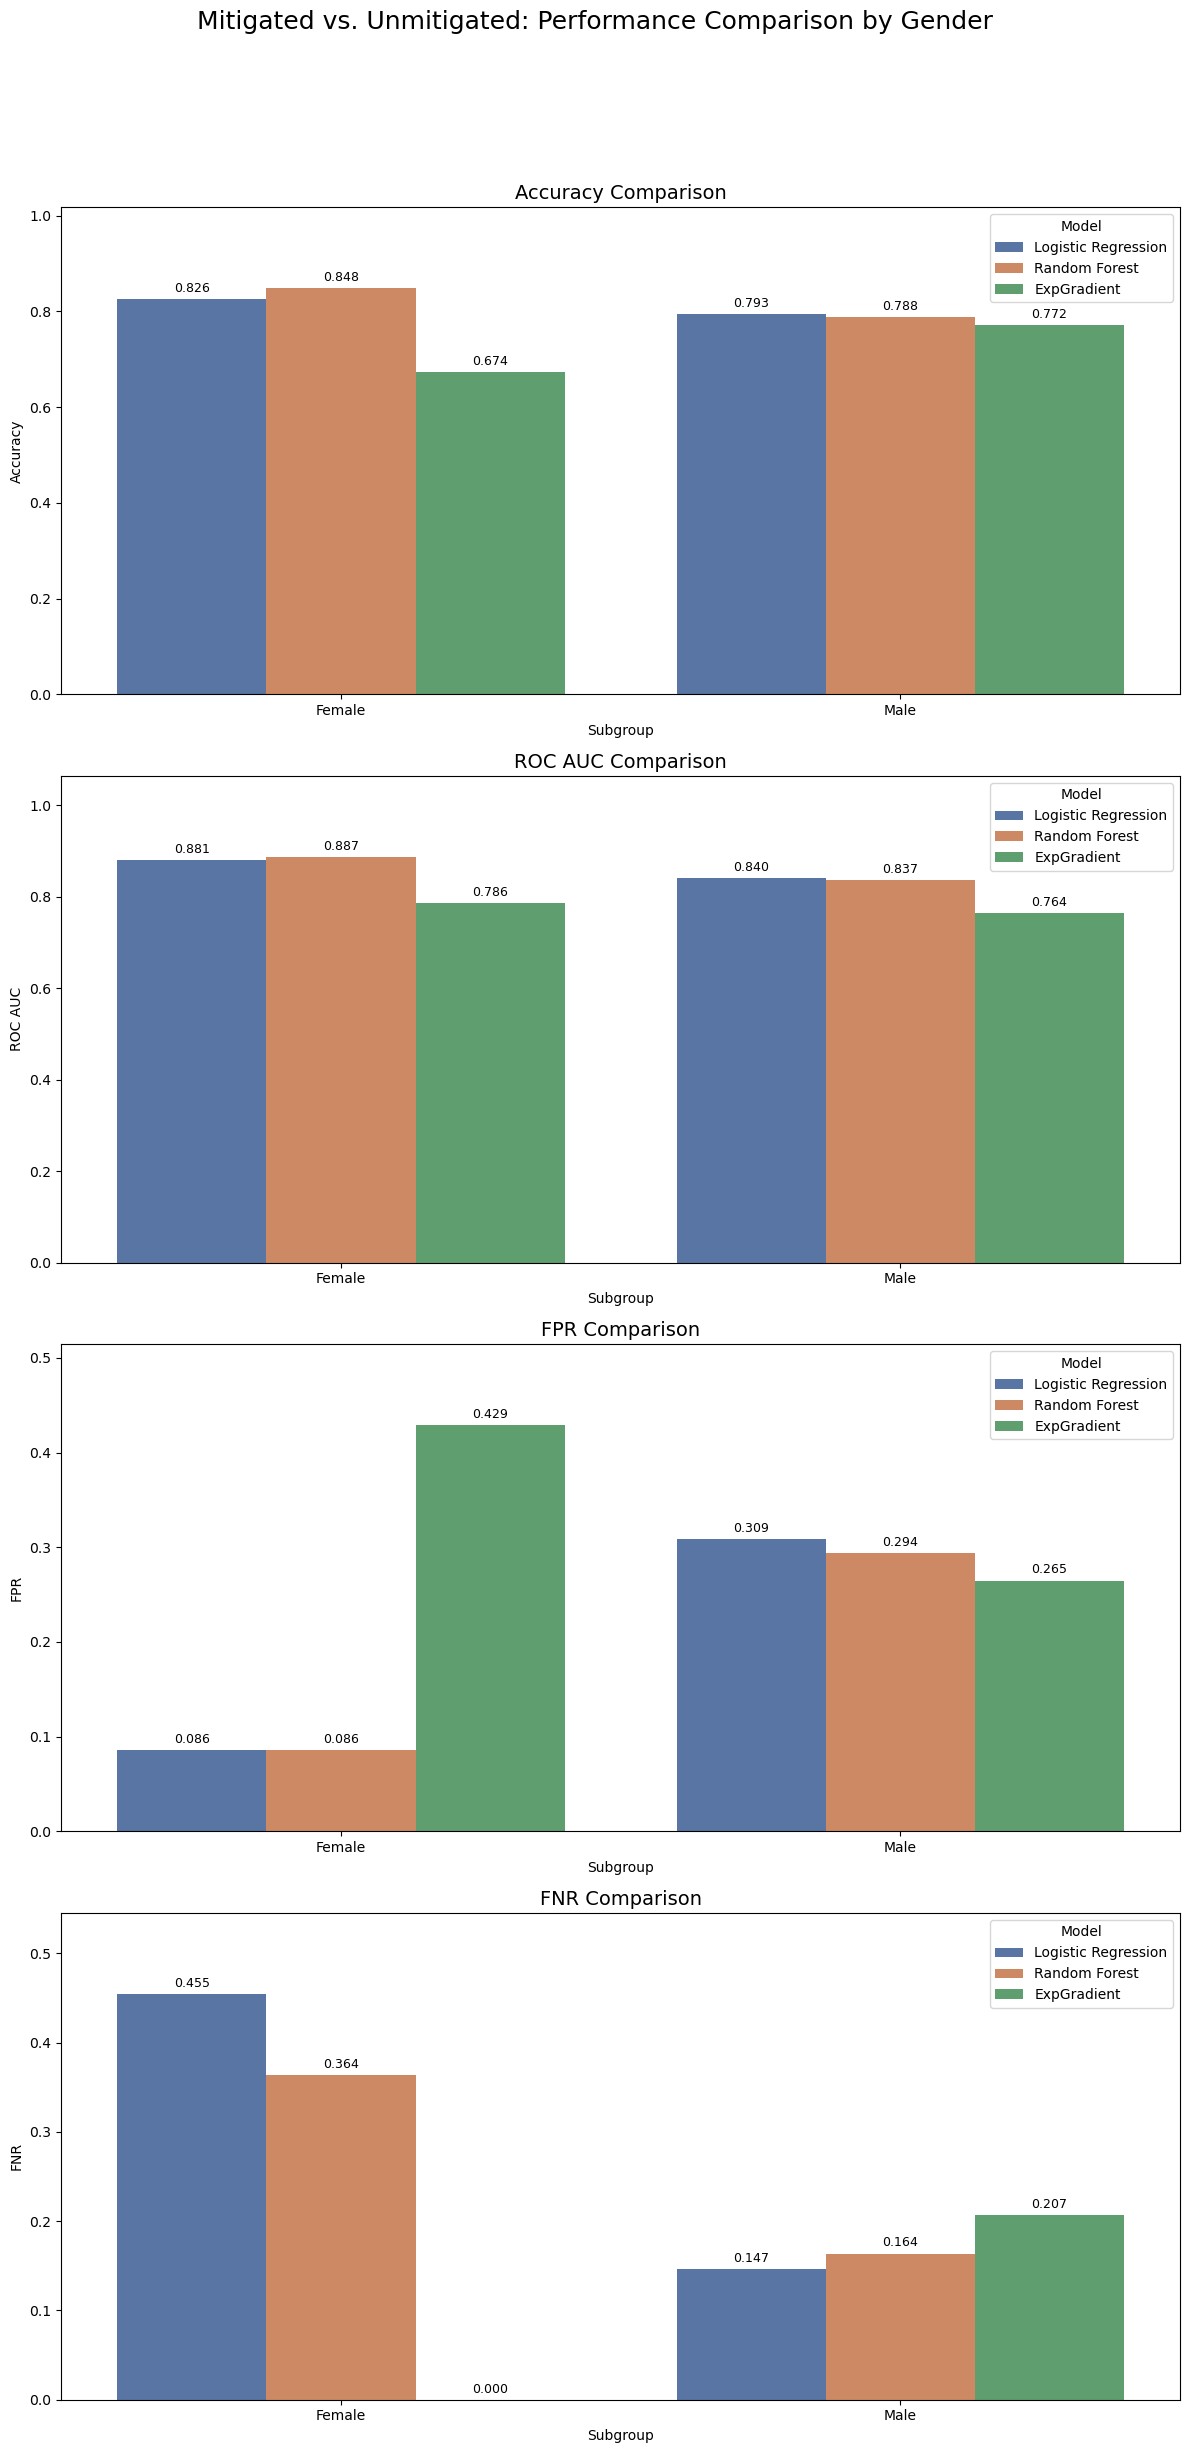

In [79]:
print("\n--- Step 5.7: Comparing Mitigated Model with Unmitigated Models (Performance Metrics) ---")

combined_bias_performance_df = pd.DataFrame()

if 'bias_performance_df' in locals() and isinstance(bias_performance_df, pd.DataFrame) and not bias_performance_df.empty:
    if not mitigated_bias_perf_df.empty:
        combined_bias_performance_df = pd.concat([bias_performance_df, mitigated_bias_perf_df], ignore_index=True)
    else:
        print("Mitigated model bias performance data is empty. Showing only unmitigated results for performance.")
        combined_bias_performance_df = bias_performance_df
elif not mitigated_bias_perf_df.empty:
    print("Warning: 'bias_performance_df' (from unmitigated models) not found or empty. Comparison will only show mitigated model performance.")
    combined_bias_performance_df = mitigated_bias_perf_df
else:
    print("No performance data available from unmitigated or mitigated models to compare.")

if not combined_bias_performance_df.empty:
    print("\n\n--- Combined Summary of Subgroup Performance (Accuracy, ROC AUC, FPR, FNR) ---")
    print(combined_bias_performance_df.to_string())

    metrics_to_plot_perf = ['Accuracy', 'ROC AUC', 'FPR', 'FNR']
    plottable_perf_metrics = [m for m in metrics_to_plot_perf if m in combined_bias_performance_df.columns and not combined_bias_performance_df[m].isnull().all()]
    
    if plottable_perf_metrics:
        num_metrics_perf = len(plottable_perf_metrics)
        fig_perf, axes_perf = plt.subplots(num_metrics_perf, 1, figsize=(12, 6 * num_metrics_perf), sharex=False)
        if num_metrics_perf == 1: axes_perf = [axes_perf] # Ensure axes_perf is always a list

        fig_perf.suptitle('Mitigated vs. Unmitigated: Performance Comparison by Gender', fontsize=18, y=1.02)
        
        for i, metric in enumerate(plottable_perf_metrics):
            plot_df_metric = combined_bias_performance_df.dropna(subset=[metric])
            if not plot_df_metric.empty:
                sns.barplot(data=plot_df_metric, x='Subgroup', y=metric, hue='Model', ax=axes_perf[i], palette='deep')
                axes_perf[i].set_title(f'{metric} Comparison', fontsize=14)
                axes_perf[i].legend(title='Model', loc='best', fontsize=10)
                for container in axes_perf[i].containers:
                    labels = [f'{val:.3f}' if pd.notna(val) else 'N/A' for val in container.datavalues]
                    axes_perf[i].bar_label(container, labels=labels, label_type='edge', fontsize=9, padding=3)
                axes_perf[i].margins(y=0.20) # Increased margin
            else:
                axes_perf[i].text(0.5, 0.5, f"No data for {metric}", horizontalalignment='center', verticalalignment='center', transform=axes_perf[i].transAxes)
                axes_perf[i].set_title(f'{metric} Comparison (No Data)', fontsize=14)
        
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()
    else:
        print("No plottable performance metrics in combined_bias_performance_df.")
else:
    print("Combined performance DataFrame is empty. Skipping visualization.")


--- Step 5.7: Comparing Mitigated Model with Unmitigated Models (Fairness Metrics DP & EOpp) ---


--- Combined Summary of Fairness Metrics (Demographic Parity & Equal Opportunity) ---
  Subgroup                Model  Samples  Positive Prediction Rate (DP)  True Positive Rate (EOpp)
0   Female  Logistic Regression       46                       0.195652                   0.545455
1     Male  Logistic Regression      184                       0.652174                   0.853448
2   Female        Random Forest       46                       0.217391                   0.636364
3     Male        Random Forest      184                       0.635870                   0.836207
4   Female          ExpGradient       46                       0.565217                   1.000000
5     Male          ExpGradient      184                       0.597826                   0.793103


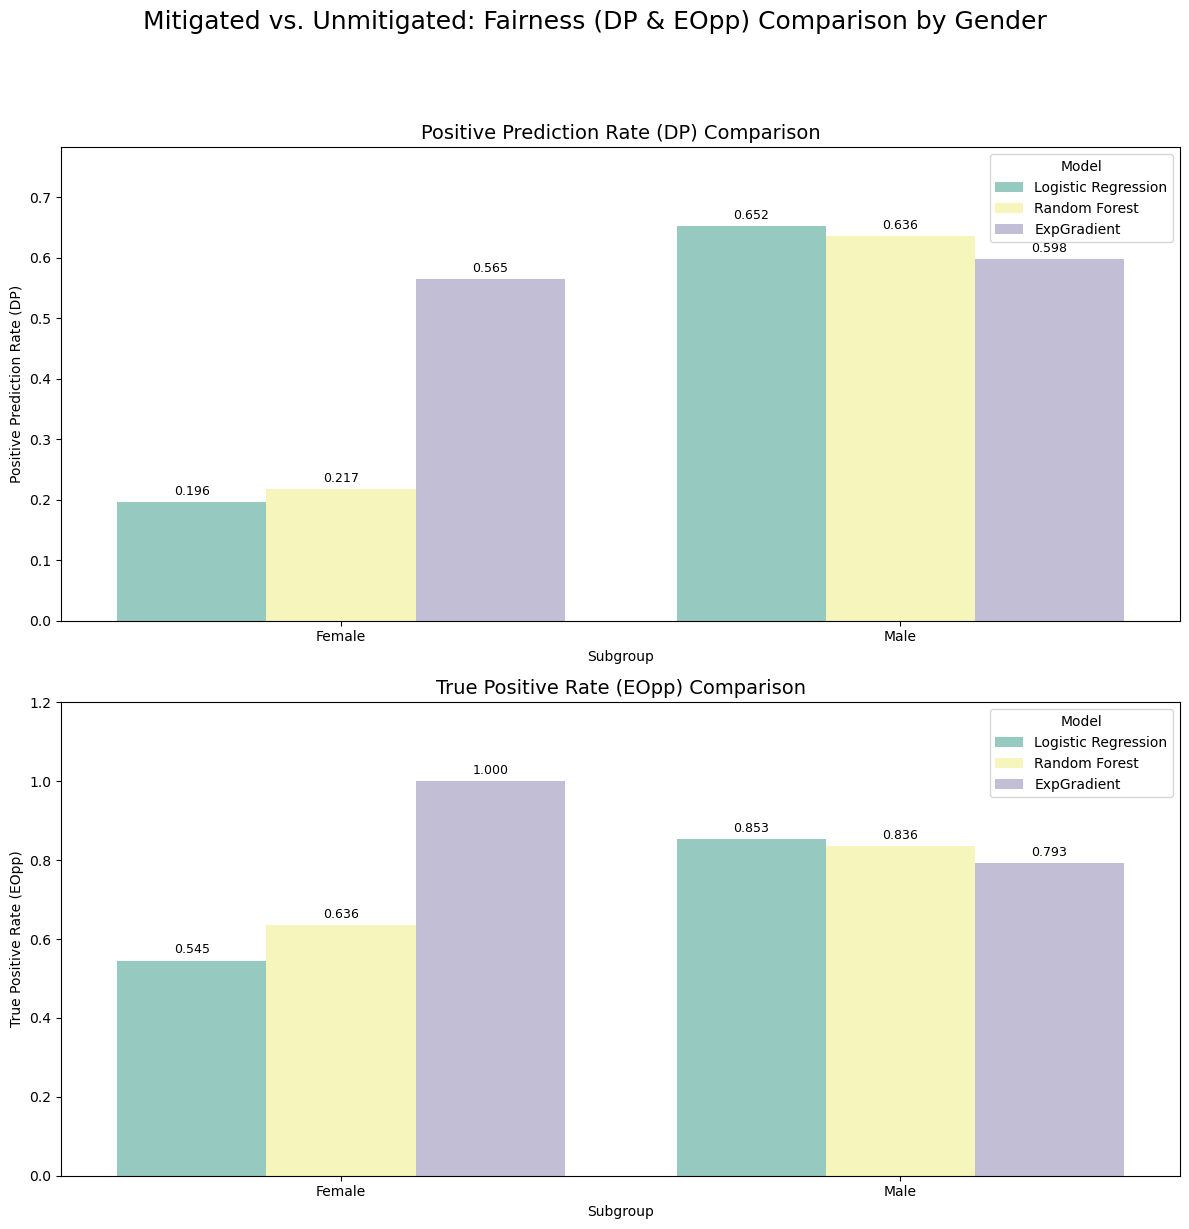


--- Chunk 5: Bias Mitigation with ExponentiatedGradient Finished ---


In [81]:
print("\n--- Step 5.7: Comparing Mitigated Model with Unmitigated Models (Fairness Metrics DP & EOpp) ---")

combined_fairness_dp_eopp_df = pd.DataFrame()

if 'fairness_gender_df_dp_eopp' in locals() and isinstance(fairness_gender_df_dp_eopp, pd.DataFrame) and not fairness_gender_df_dp_eopp.empty:
    if not mitigated_fairness_dp_eopp_df.empty:
        combined_fairness_dp_eopp_df = pd.concat([fairness_gender_df_dp_eopp, mitigated_fairness_dp_eopp_df], ignore_index=True)
    else:
        print("Mitigated model fairness data (DP & EOpp) is empty. Showing only unmitigated results for fairness.")
        combined_fairness_dp_eopp_df = fairness_gender_df_dp_eopp
elif not mitigated_fairness_dp_eopp_df.empty:
    print("Warning: 'fairness_gender_df_dp_eopp' (from unmitigated models) not found or empty. Comparison will only show mitigated model fairness.")
    combined_fairness_dp_eopp_df = mitigated_fairness_dp_eopp_df
else:
    print("No fairness data (DP & EOpp) available from unmitigated or mitigated models to compare.")

if not combined_fairness_dp_eopp_df.empty:
    print("\n\n--- Combined Summary of Fairness Metrics (Demographic Parity & Equal Opportunity) ---")
    print(combined_fairness_dp_eopp_df.to_string())
    
    metrics_to_plot_fairness = ['Positive Prediction Rate (DP)', 'True Positive Rate (EOpp)']
    plottable_fairness_metrics_dp_eopp = [m for m in metrics_to_plot_fairness if m in combined_fairness_dp_eopp_df.columns and not combined_fairness_dp_eopp_df[m].isnull().all()]

    if plottable_fairness_metrics_dp_eopp:
        num_metrics_fairness = len(plottable_fairness_metrics_dp_eopp)
        fig_fairness, axes_fairness = plt.subplots(num_metrics_fairness, 1, figsize=(12, 6 * num_metrics_fairness), sharex=False)
        if num_metrics_fairness == 1: axes_fairness = [axes_fairness] # Ensure axes_fairness is always a list

        fig_fairness.suptitle('Mitigated vs. Unmitigated: Fairness (DP & EOpp) Comparison by Gender', fontsize=18, y=1.02)
        
        for i, metric in enumerate(plottable_fairness_metrics_dp_eopp):
            plot_df_metric_fairness = combined_fairness_dp_eopp_df.dropna(subset=[metric])
            if not plot_df_metric_fairness.empty:
                sns.barplot(data=plot_df_metric_fairness, x='Subgroup', y=metric, hue='Model', ax=axes_fairness[i], palette='Set3')
                axes_fairness[i].set_title(f'{metric} Comparison', fontsize=14)
                axes_fairness[i].legend(title='Model', loc='best', fontsize=10)
                for container in axes_fairness[i].containers:
                    labels = [f'{val:.3f}' if pd.notna(val) else 'N/A' for val in container.datavalues]
                    axes_fairness[i].bar_label(container, labels=labels, label_type='edge', fontsize=9, padding=3)
                axes_fairness[i].margins(y=0.20) # Increased margin
            else:
                axes_fairness[i].text(0.5, 0.5, f"No data for {metric}", horizontalalignment='center', verticalalignment='center', transform=axes_fairness[i].transAxes)
                axes_fairness[i].set_title(f'{metric} Comparison (No Data)', fontsize=14)

        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()
    else:
        print("No plottable fairness metrics (DP & EOpp) in combined_fairness_dp_eopp_df.")
else:
    print("Combined fairness DataFrame (DP & EOpp) is empty. Skipping visualization.")

print("\n--- Chunk 5: Bias Mitigation with ExponentiatedGradient Finished ---")

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression # For the base estimator
from sklearn.ensemble import RandomForestClassifier # For the base estimator
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from fairlearn.postprocessing import ThresholdOptimizer
# Note: We don't import EqualizedOdds object from fairlearn.reductions for ThresholdOptimizer's constraint string.

import warnings
warnings.filterwarnings('ignore')

# --- Assume variables from previous Chunks are available: ---
# Chunk 1: X_train, X_test, y_train, y_test (original splits)
#          X_train_processed, X_test_processed (NumPy arrays after ColumnTransformer)
#          SENSITIVE_ATTRIBUTE (string, e.g., 'sex')
# Chunk 2: log_reg, rand_forest (TRAINED unmitigated models)
#          y_pred_log_reg, y_prob_log_reg (predictions from unmitigated LR)
#          y_pred_rand_forest, y_prob_rand_forest (predictions from unmitigated RF)
# Chunk 3: evaluate_subgroup_performance (helper function - MUST BE DEFINED if in new session)
#          X_test_original_sensitive_attr (DataFrame with 'sex' for test set)
#          y_test_series (pandas Series of true labels for test set)
# Chunk 4: calculate_fairness_metrics_dp_eopp (helper function - MUST BE DEFINED if in new session)
#          POSITIVE_CLASS_LABEL
# Chunk 5: combined_bias_performance_df (DataFrame with metrics for unmitigated LR, RF, and ExpGradient)
#          combined_fairness_dp_eopp_df (DataFrame with DP & EOpp for unmitigated LR, RF, and ExpGradient)

# --- Placeholder for helper functions if not in global scope (should be defined in previous cells) ---
if 'evaluate_subgroup_performance' not in locals():
    print("Defining dummy 'evaluate_subgroup_performance' function. Ensure the real one is loaded from Chunk 3.")
    def evaluate_subgroup_performance(y_true_full, y_pred_full, y_prob_full, subgroup_mask, subgroup_name, model_name):
        print(f"DUMMY: Evaluating {model_name} for {subgroup_name}")
        if subgroup_mask.sum() == 0: return None
        return {'Subgroup': subgroup_name, 'Model': model_name, 'Accuracy': 0.5, 'ROC AUC': 0.5, 'FPR': 0.5, 'FNR': 0.5, 'Samples': subgroup_mask.sum()}

if 'calculate_fairness_metrics_dp_eopp' not in locals():
    print("Defining dummy 'calculate_fairness_metrics_dp_eopp' function. Ensure the real one is loaded from Chunk 4.")
    def calculate_fairness_metrics_dp_eopp(y_true_full, y_pred_labels_full, group_mask, subgroup_name, model_name):
        print(f"DUMMY: Calculating DP/EOpp for {model_name} for {subgroup_name}")
        if group_mask.sum() == 0: return None
        return {'Subgroup': subgroup_name, 'Model': model_name, 'Samples': group_mask.sum(), 'Positive Prediction Rate (DP)': 0.5, 'True Positive Rate (EOpp)': 0.5}
# --- End Placeholder ---

# --- Verification of Previous Chunk Variables ---
essential_vars_c6 = [
    'log_reg', 'rand_forest', 'y_prob_log_reg', 'y_prob_rand_forest',
    'y_test_series', 'X_test_original_sensitive_attr', 'SENSITIVE_ATTRIBUTE',
    'X_test_processed'
]
comparison_dfs_c6 = ['combined_bias_performance_df', 'combined_fairness_dp_eopp_df']

# Default SENSITIVE_ATTRIBUTE if not found (for placeholder creation)
if 'SENSITIVE_ATTRIBUTE' not in locals():
    print("Warning: 'SENSITIVE_ATTRIBUTE' not found globally. Defaulting to 'sex' for placeholder creation.")
    SENSITIVE_ATTRIBUTE = 'sex'

for var in essential_vars_c6:
    if var not in locals():
        print(f"Error: Essential variable '{var}' from previous chunks not found for Chunk 6.")
        # Fallback for demonstration (highly simplified and NOT FOR ANALYSIS)
        _n_test_samples, _n_features = 75, 10
        if var == 'X_test_processed': X_test_processed = np.random.rand(_n_test_samples, _n_features)
        elif var == 'y_test_series': y_test_series = pd.Series(np.random.randint(0, 2, _n_test_samples))
        elif var == 'X_test_original_sensitive_attr': X_test_original_sensitive_attr = pd.DataFrame({SENSITIVE_ATTRIBUTE: np.random.randint(0, 2, _n_test_samples)}, index=y_test_series.index if 'y_test_series' in locals() else None)
        elif var == 'y_prob_log_reg': y_prob_log_reg = np.random.rand(_n_test_samples)
        elif var == 'y_prob_rand_forest': y_prob_rand_forest = np.random.rand(_n_test_samples)
        elif var == 'log_reg': log_reg = LogisticRegression(max_iter=10).fit(np.random.rand(10,2), np.random.randint(0,2,10)) # Minimal dummy
        elif var == 'rand_forest': rand_forest = RandomForestClassifier(n_estimators=5).fit(np.random.rand(10,2), np.random.randint(0,2,10)) # Minimal dummy
        print(f"Defined DUMMY for '{var}'. Results will be illustrative only.")

for df_name in comparison_dfs_c6:
    if df_name not in locals():
        print(f"Warning: DataFrame '{df_name}' for comparison not found. Comparisons might be incomplete.")
        if df_name == 'combined_bias_performance_df':
            combined_bias_performance_df = pd.DataFrame(columns=['Subgroup', 'Model', 'Accuracy', 'ROC AUC', 'FPR', 'FNR', 'Samples'])
        elif df_name == 'combined_fairness_dp_eopp_df':
            combined_fairness_dp_eopp_df = pd.DataFrame(columns=['Subgroup', 'Model', 'Samples', 'Positive Prediction Rate (DP)', 'True Positive Rate (EOpp)'])

if 'POSITIVE_CLASS_LABEL' not in locals():
    POSITIVE_CLASS_LABEL = 1 # Default if not defined in Chunk 4
    print(f"INFO: POSITIVE_CLASS_LABEL not found, defaulting to {POSITIVE_CLASS_LABEL} for Chunk 6.")
else:
    print("Using variables from previous chunks for Mitigation with ThresholdOptimizer.")


print("\n--- Chunk 6: Bias Mitigation with ThresholdOptimizer (Corrected) ---")
print("\n--- Step 6.1: Setting up ThresholdOptimizer ---")

# Using "equalized_odds" string for the constraint.
constraint_string_to = "equalized_odds" # Can also be "demographic_parity"
print(f"Constraint for ThresholdOptimizer: {constraint_string_to}")

Using variables from previous chunks for Mitigation with ThresholdOptimizer.

--- Chunk 6: Bias Mitigation with ThresholdOptimizer (Corrected) ---

--- Step 6.1: Setting up ThresholdOptimizer ---
Constraint for ThresholdOptimizer: equalized_odds


In [85]:
print("\n--- Step 6.2: Applying ThresholdOptimizer ---")

optimizer_lr_fitted = False
optimizer_rf_fitted = False
y_pred_to_lr = None
y_pred_to_rf = None

# --- ThresholdOptimizer for Logistic Regression ---
print("\n--- Applying ThresholdOptimizer to Logistic Regression ---")
if 'log_reg' in locals() and hasattr(log_reg, 'predict_proba') and \
   'X_test_processed' in locals() and X_test_processed.size > 0 and \
   'y_test_series' in locals() and y_test_series.size > 0 and \
   'X_test_original_sensitive_attr' in locals() and not X_test_original_sensitive_attr.empty and \
   SENSITIVE_ATTRIBUTE in X_test_original_sensitive_attr.columns:

    optimizer_lr = ThresholdOptimizer(
        estimator=log_reg,
        constraints=constraint_string_to,
        objective="accuracy_score", # You can also use "balanced_accuracy_score", "roc_auc_score" (if predict_method='predict_proba')
        prefit=True,
        predict_method='predict_proba'
    )
    try:
        optimizer_lr.fit(
            X_test_processed,
            y_test_series,
            sensitive_features=X_test_original_sensitive_attr[SENSITIVE_ATTRIBUTE]
        )
        print("ThresholdOptimizer fitted for Logistic Regression.")
        y_pred_to_lr = optimizer_lr.predict(
            X_test_processed,
            sensitive_features=X_test_original_sensitive_attr[SENSITIVE_ATTRIBUTE]
        )
        print("Predictions made with ThresholdOptimizer for Logistic Regression.")
        optimizer_lr_fitted = True
    except Exception as e:
        print(f"Error fitting or predicting with ThresholdOptimizer for LR: {e}")
else:
    print("Skipping ThresholdOptimizer for LR due to missing prerequisites.")


# --- ThresholdOptimizer for Random Forest ---
print("\n--- Applying ThresholdOptimizer to Random Forest ---")
if 'rand_forest' in locals() and hasattr(rand_forest, 'predict_proba') and \
   'X_test_processed' in locals() and X_test_processed.size > 0 and \
   'y_test_series' in locals() and y_test_series.size > 0 and \
   'X_test_original_sensitive_attr' in locals() and not X_test_original_sensitive_attr.empty and \
   SENSITIVE_ATTRIBUTE in X_test_original_sensitive_attr.columns:

    optimizer_rf = ThresholdOptimizer(
        estimator=rand_forest,
        constraints=constraint_string_to,
        objective="accuracy_score",
        prefit=True,
        predict_method='predict_proba'
    )
    try:
        optimizer_rf.fit(
            X_test_processed,
            y_test_series,
            sensitive_features=X_test_original_sensitive_attr[SENSITIVE_ATTRIBUTE]
        )
        print("ThresholdOptimizer fitted for Random Forest.")
        y_pred_to_rf = optimizer_rf.predict(
            X_test_processed,
            sensitive_features=X_test_original_sensitive_attr[SENSITIVE_ATTRIBUTE]
        )
        print("Predictions made with ThresholdOptimizer for Random Forest.")
        optimizer_rf_fitted = True
    except Exception as e:
        print(f"Error fitting or predicting with ThresholdOptimizer for RF: {e}")
else:
    print("Skipping ThresholdOptimizer for RF due to missing prerequisites.")


--- Step 6.2: Applying ThresholdOptimizer ---

--- Applying ThresholdOptimizer to Logistic Regression ---
ThresholdOptimizer fitted for Logistic Regression.
Predictions made with ThresholdOptimizer for Logistic Regression.

--- Applying ThresholdOptimizer to Random Forest ---
ThresholdOptimizer fitted for Random Forest.
Predictions made with ThresholdOptimizer for Random Forest.


In [87]:
print("\n--- Step 6.2: Applying ThresholdOptimizer ---")

optimizer_lr_fitted = False
optimizer_rf_fitted = False
y_pred_to_lr = None
y_pred_to_rf = None

# --- ThresholdOptimizer for Logistic Regression ---
print("\n--- Applying ThresholdOptimizer to Logistic Regression ---")
if 'log_reg' in locals() and hasattr(log_reg, 'predict_proba') and \
   'X_test_processed' in locals() and X_test_processed.size > 0 and \
   'y_test_series' in locals() and y_test_series.size > 0 and \
   'X_test_original_sensitive_attr' in locals() and not X_test_original_sensitive_attr.empty and \
   SENSITIVE_ATTRIBUTE in X_test_original_sensitive_attr.columns:

    optimizer_lr = ThresholdOptimizer(
        estimator=log_reg,
        constraints=constraint_string_to,
        objective="accuracy_score", # You can also use "balanced_accuracy_score", "roc_auc_score" (if predict_method='predict_proba')
        prefit=True,
        predict_method='predict_proba'
    )
    try:
        optimizer_lr.fit(
            X_test_processed,
            y_test_series,
            sensitive_features=X_test_original_sensitive_attr[SENSITIVE_ATTRIBUTE]
        )
        print("ThresholdOptimizer fitted for Logistic Regression.")
        y_pred_to_lr = optimizer_lr.predict(
            X_test_processed,
            sensitive_features=X_test_original_sensitive_attr[SENSITIVE_ATTRIBUTE]
        )
        print("Predictions made with ThresholdOptimizer for Logistic Regression.")
        optimizer_lr_fitted = True
    except Exception as e:
        print(f"Error fitting or predicting with ThresholdOptimizer for LR: {e}")
else:
    print("Skipping ThresholdOptimizer for LR due to missing prerequisites.")


# --- ThresholdOptimizer for Random Forest ---
print("\n--- Applying ThresholdOptimizer to Random Forest ---")
if 'rand_forest' in locals() and hasattr(rand_forest, 'predict_proba') and \
   'X_test_processed' in locals() and X_test_processed.size > 0 and \
   'y_test_series' in locals() and y_test_series.size > 0 and \
   'X_test_original_sensitive_attr' in locals() and not X_test_original_sensitive_attr.empty and \
   SENSITIVE_ATTRIBUTE in X_test_original_sensitive_attr.columns:

    optimizer_rf = ThresholdOptimizer(
        estimator=rand_forest,
        constraints=constraint_string_to,
        objective="accuracy_score",
        prefit=True,
        predict_method='predict_proba'
    )
    try:
        optimizer_rf.fit(
            X_test_processed,
            y_test_series,
            sensitive_features=X_test_original_sensitive_attr[SENSITIVE_ATTRIBUTE]
        )
        print("ThresholdOptimizer fitted for Random Forest.")
        y_pred_to_rf = optimizer_rf.predict(
            X_test_processed,
            sensitive_features=X_test_original_sensitive_attr[SENSITIVE_ATTRIBUTE]
        )
        print("Predictions made with ThresholdOptimizer for Random Forest.")
        optimizer_rf_fitted = True
    except Exception as e:
        print(f"Error fitting or predicting with ThresholdOptimizer for RF: {e}")
else:
    print("Skipping ThresholdOptimizer for RF due to missing prerequisites.")


--- Step 6.2: Applying ThresholdOptimizer ---

--- Applying ThresholdOptimizer to Logistic Regression ---
ThresholdOptimizer fitted for Logistic Regression.
Predictions made with ThresholdOptimizer for Logistic Regression.

--- Applying ThresholdOptimizer to Random Forest ---
ThresholdOptimizer fitted for Random Forest.
Predictions made with ThresholdOptimizer for Random Forest.


In [89]:
print("\n--- Step 6.3: Overall Evaluation of Threshold-Optimized Models ---")

if y_pred_to_lr is not None and 'y_test_series' in locals() and y_test_series.size > 0:
    print("\n--- Overall Evaluation: ThresholdOptimizer on Logistic Regression (TO_LR) ---")
    print(f"Accuracy (TO_LR): {accuracy_score(y_test_series, y_pred_to_lr):.4f}")
    # ROC AUC for TO is typically based on the original model's scores, as TO adjusts thresholds on predictions.
    # However, if ThresholdOptimizer provides a predict_proba, that could be used, but it's not standard.
    # For consistency, we'll show ROC AUC from original scores for LR if available.
    if 'y_prob_log_reg' in locals() and y_prob_log_reg.size > 0 and len(np.unique(y_test_series)) > 1:
        print(f"ROC AUC (based on Original LR scores): {roc_auc_score(y_test_series, y_prob_log_reg):.4f}")
    else:
        print("ROC AUC (Original LR): Not applicable or probabilities not available.")
    print("Classification Report (TO_LR):\n", classification_report(y_test_series, y_pred_to_lr, zero_division=0))
    print("Confusion Matrix (TO_LR):\n", confusion_matrix(y_test_series, y_pred_to_lr))
else:
    print("\nSkipping TO_LR overall evaluation: Predictions or y_test_series not available.")


if y_pred_to_rf is not None and 'y_test_series' in locals() and y_test_series.size > 0:
    print("\n--- Overall Evaluation: ThresholdOptimizer on Random Forest (TO_RF) ---")
    print(f"Accuracy (TO_RF): {accuracy_score(y_test_series, y_pred_to_rf):.4f}")
    # Similar to TO_LR, ROC AUC is shown based on original RF scores.
    if 'y_prob_rand_forest' in locals() and y_prob_rand_forest.size > 0 and len(np.unique(y_test_series)) > 1:
        print(f"ROC AUC (based on Original RF scores): {roc_auc_score(y_test_series, y_prob_rand_forest):.4f}")
    else:
        print("ROC AUC (Original RF): Not applicable or probabilities not available.")
    print("Classification Report (TO_RF):\n", classification_report(y_test_series, y_pred_to_rf, zero_division=0))
    print("Confusion Matrix (TO_RF):\n", confusion_matrix(y_test_series, y_pred_to_rf))
else:
    print("\nSkipping TO_RF overall evaluation: Predictions or y_test_series not available.")


--- Step 6.3: Overall Evaluation of Threshold-Optimized Models ---

--- Overall Evaluation: ThresholdOptimizer on Logistic Regression (TO_LR) ---
Accuracy (TO_LR): 0.7957
ROC AUC (based on Original LR scores): 0.8701
Classification Report (TO_LR):
               precision    recall  f1-score   support

           0       0.82      0.70      0.75       103
           1       0.78      0.87      0.83       127

    accuracy                           0.80       230
   macro avg       0.80      0.79      0.79       230
weighted avg       0.80      0.80      0.79       230

Confusion Matrix (TO_LR):
 [[ 72  31]
 [ 16 111]]

--- Overall Evaluation: ThresholdOptimizer on Random Forest (TO_RF) ---
Accuracy (TO_RF): 0.7870
ROC AUC (based on Original RF scores): 0.8638
Classification Report (TO_RF):
               precision    recall  f1-score   support

           0       0.75      0.79      0.77       103
           1       0.82      0.79      0.80       127

    accuracy                     

In [91]:
print("\n--- Steps 6.4 & 6.5: Subgroup Performance and Fairness for ThresholdOptimized Models ---")

to_lr_bias_metrics_list = []
to_lr_fairness_dp_eopp_list = []
to_rf_bias_metrics_list = []
to_rf_fairness_dp_eopp_list = []

# Ensure sensitive attribute data and y_test_series are valid
if ('X_test_original_sensitive_attr' in locals() and not X_test_original_sensitive_attr.empty and
    SENSITIVE_ATTRIBUTE in X_test_original_sensitive_attr.columns and
    'y_test_series' in locals() and not y_test_series.empty):

    female_mask = (X_test_original_sensitive_attr[SENSITIVE_ATTRIBUTE] == 0)
    male_mask = (X_test_original_sensitive_attr[SENSITIVE_ATTRIBUTE] == 1)

    # --- For ThresholdOptimizer on Logistic Regression (TO_LR) ---
    if y_pred_to_lr is not None and 'y_prob_log_reg' in locals() and y_prob_log_reg.size > 0 :
        print("\n" + "="*30 + "\nBias & Fairness: ThresholdOptimizer on LR (TO_LR)\n" + "="*30)
        if female_mask.sum() > 0:
            lr_female_perf = evaluate_subgroup_performance(y_test_series, y_pred_to_lr, y_prob_log_reg, female_mask, 'Female', 'TO_LR')
            if lr_female_perf: to_lr_bias_metrics_list.append(lr_female_perf)
            lr_female_fair = calculate_fairness_metrics_dp_eopp(y_test_series, y_pred_to_lr, female_mask, 'Female', 'TO_LR')
            if lr_female_fair: to_lr_fairness_dp_eopp_list.append(lr_female_fair)
        else: print("No Female samples for TO_LR subgroup analysis.")

        if male_mask.sum() > 0:
            lr_male_perf = evaluate_subgroup_performance(y_test_series, y_pred_to_lr, y_prob_log_reg, male_mask, 'Male', 'TO_LR')
            if lr_male_perf: to_lr_bias_metrics_list.append(lr_male_perf)
            lr_male_fair = calculate_fairness_metrics_dp_eopp(y_test_series, y_pred_to_lr, male_mask, 'Male', 'TO_LR')
            if lr_male_fair: to_lr_fairness_dp_eopp_list.append(lr_male_fair)
        else: print("No Male samples for TO_LR subgroup analysis.")
    else:
        print("\nSkipping TO_LR subgroup analysis: Predictions or original probabilities not available.")

    # --- For ThresholdOptimizer on Random Forest (TO_RF) ---
    if y_pred_to_rf is not None and 'y_prob_rand_forest' in locals() and y_prob_rand_forest.size > 0:
        print("\n" + "="*30 + "\nBias & Fairness: ThresholdOptimizer on RF (TO_RF)\n" + "="*30)
        if female_mask.sum() > 0:
            rf_female_perf = evaluate_subgroup_performance(y_test_series, y_pred_to_rf, y_prob_rand_forest, female_mask, 'Female', 'TO_RF')
            if rf_female_perf: to_rf_bias_metrics_list.append(rf_female_perf)
            rf_female_fair = calculate_fairness_metrics_dp_eopp(y_test_series, y_pred_to_rf, female_mask, 'Female', 'TO_RF')
            if rf_female_fair: to_rf_fairness_dp_eopp_list.append(rf_female_fair)
        else: print("No Female samples for TO_RF subgroup analysis.")
            
        if male_mask.sum() > 0:
            rf_male_perf = evaluate_subgroup_performance(y_test_series, y_pred_to_rf, y_prob_rand_forest, male_mask, 'Male', 'TO_RF')
            if rf_male_perf: to_rf_bias_metrics_list.append(rf_male_perf)
            rf_male_fair = calculate_fairness_metrics_dp_eopp(y_test_series, y_pred_to_rf, male_mask, 'Male', 'TO_RF')
            if rf_male_fair: to_rf_fairness_dp_eopp_list.append(rf_male_fair)
        else: print("No Male samples for TO_RF subgroup analysis.")
    else:
        print("\nSkipping TO_RF subgroup analysis: Predictions or original probabilities not available.")
else:
    print("\nSkipping subgroup analysis for TO models: Sensitive attribute data or y_test_series not valid.")


to_lr_bias_perf_df = pd.DataFrame(to_lr_bias_metrics_list)
to_lr_fairness_df = pd.DataFrame(to_lr_fairness_dp_eopp_list)
to_rf_bias_perf_df = pd.DataFrame(to_rf_bias_metrics_list)
to_rf_fairness_df = pd.DataFrame(to_rf_fairness_dp_eopp_list)

# Display the new DataFrames
if not to_lr_bias_perf_df.empty:
    print("\nThresholdOptimized LR - Bias Performance:")
    print(to_lr_bias_perf_df.to_string())
if not to_lr_fairness_df.empty:
    print("\nThresholdOptimized LR - Fairness (DP & EOpp):")
    print(to_lr_fairness_df.to_string())
if not to_rf_bias_perf_df.empty:
    print("\nThresholdOptimized RF - Bias Performance:")
    print(to_rf_bias_perf_df.to_string())
if not to_rf_fairness_df.empty:
    print("\nThresholdOptimized RF - Fairness (DP & EOpp):")
    print(to_rf_fairness_df.to_string())


--- Steps 6.4 & 6.5: Subgroup Performance and Fairness for ThresholdOptimized Models ---

Bias & Fairness: ThresholdOptimizer on LR (TO_LR)

--- TO_LR Evaluation for Female ---
Test Samples: 46
Accuracy: 0.7826
ROC AUC: 0.8805
FPR (Type I Error - Predict disease when absent): 0.2857
FNR (Type II Error - Predict no disease when present): 0.0000

--- Fairness Metrics: TO_LR for Female ---
Samples in group: 46
Positive Prediction Rate (Demographic Parity): 0.4565
True Positive Rate (Equal Opportunity): 1.0000

--- TO_LR Evaluation for Male ---
Test Samples: 184
Accuracy: 0.7989
ROC AUC: 0.8401
FPR (Type I Error - Predict disease when absent): 0.3088
FNR (Type II Error - Predict no disease when present): 0.1379

--- Fairness Metrics: TO_LR for Male ---
Samples in group: 184
Positive Prediction Rate (Demographic Parity): 0.6576
True Positive Rate (Equal Opportunity): 0.8621

Bias & Fairness: ThresholdOptimizer on RF (TO_RF)

--- TO_RF Evaluation for Female ---
Test Samples: 46
Accuracy: 0.


--- Step 6.6: Comprehensive Comparison - Performance Visualization ---


--- Expanded Summary of Subgroup Performance (All Models) ---
  Subgroup                Model  Accuracy   ROC AUC       FPR       FNR  Samples
0   Female  Logistic Regression  0.826087  0.880519  0.085714  0.454545       46
1     Male  Logistic Regression  0.793478  0.840137  0.308824  0.146552      184
2   Female        Random Forest  0.847826  0.887013  0.085714  0.363636       46
3     Male        Random Forest  0.788043  0.836714  0.294118  0.163793      184
4   Female          ExpGradient  0.673913  0.785714  0.428571  0.000000       46
5     Male          ExpGradient  0.771739  0.764199  0.264706  0.206897      184
6   Female                TO_LR  0.782609  0.880519  0.285714  0.000000       46
7     Male                TO_LR  0.798913  0.840137  0.308824  0.137931      184
8   Female                TO_RF  0.760870  0.887013  0.228571  0.272727       46
9     Male                TO_RF  0.793478  0.836714  0

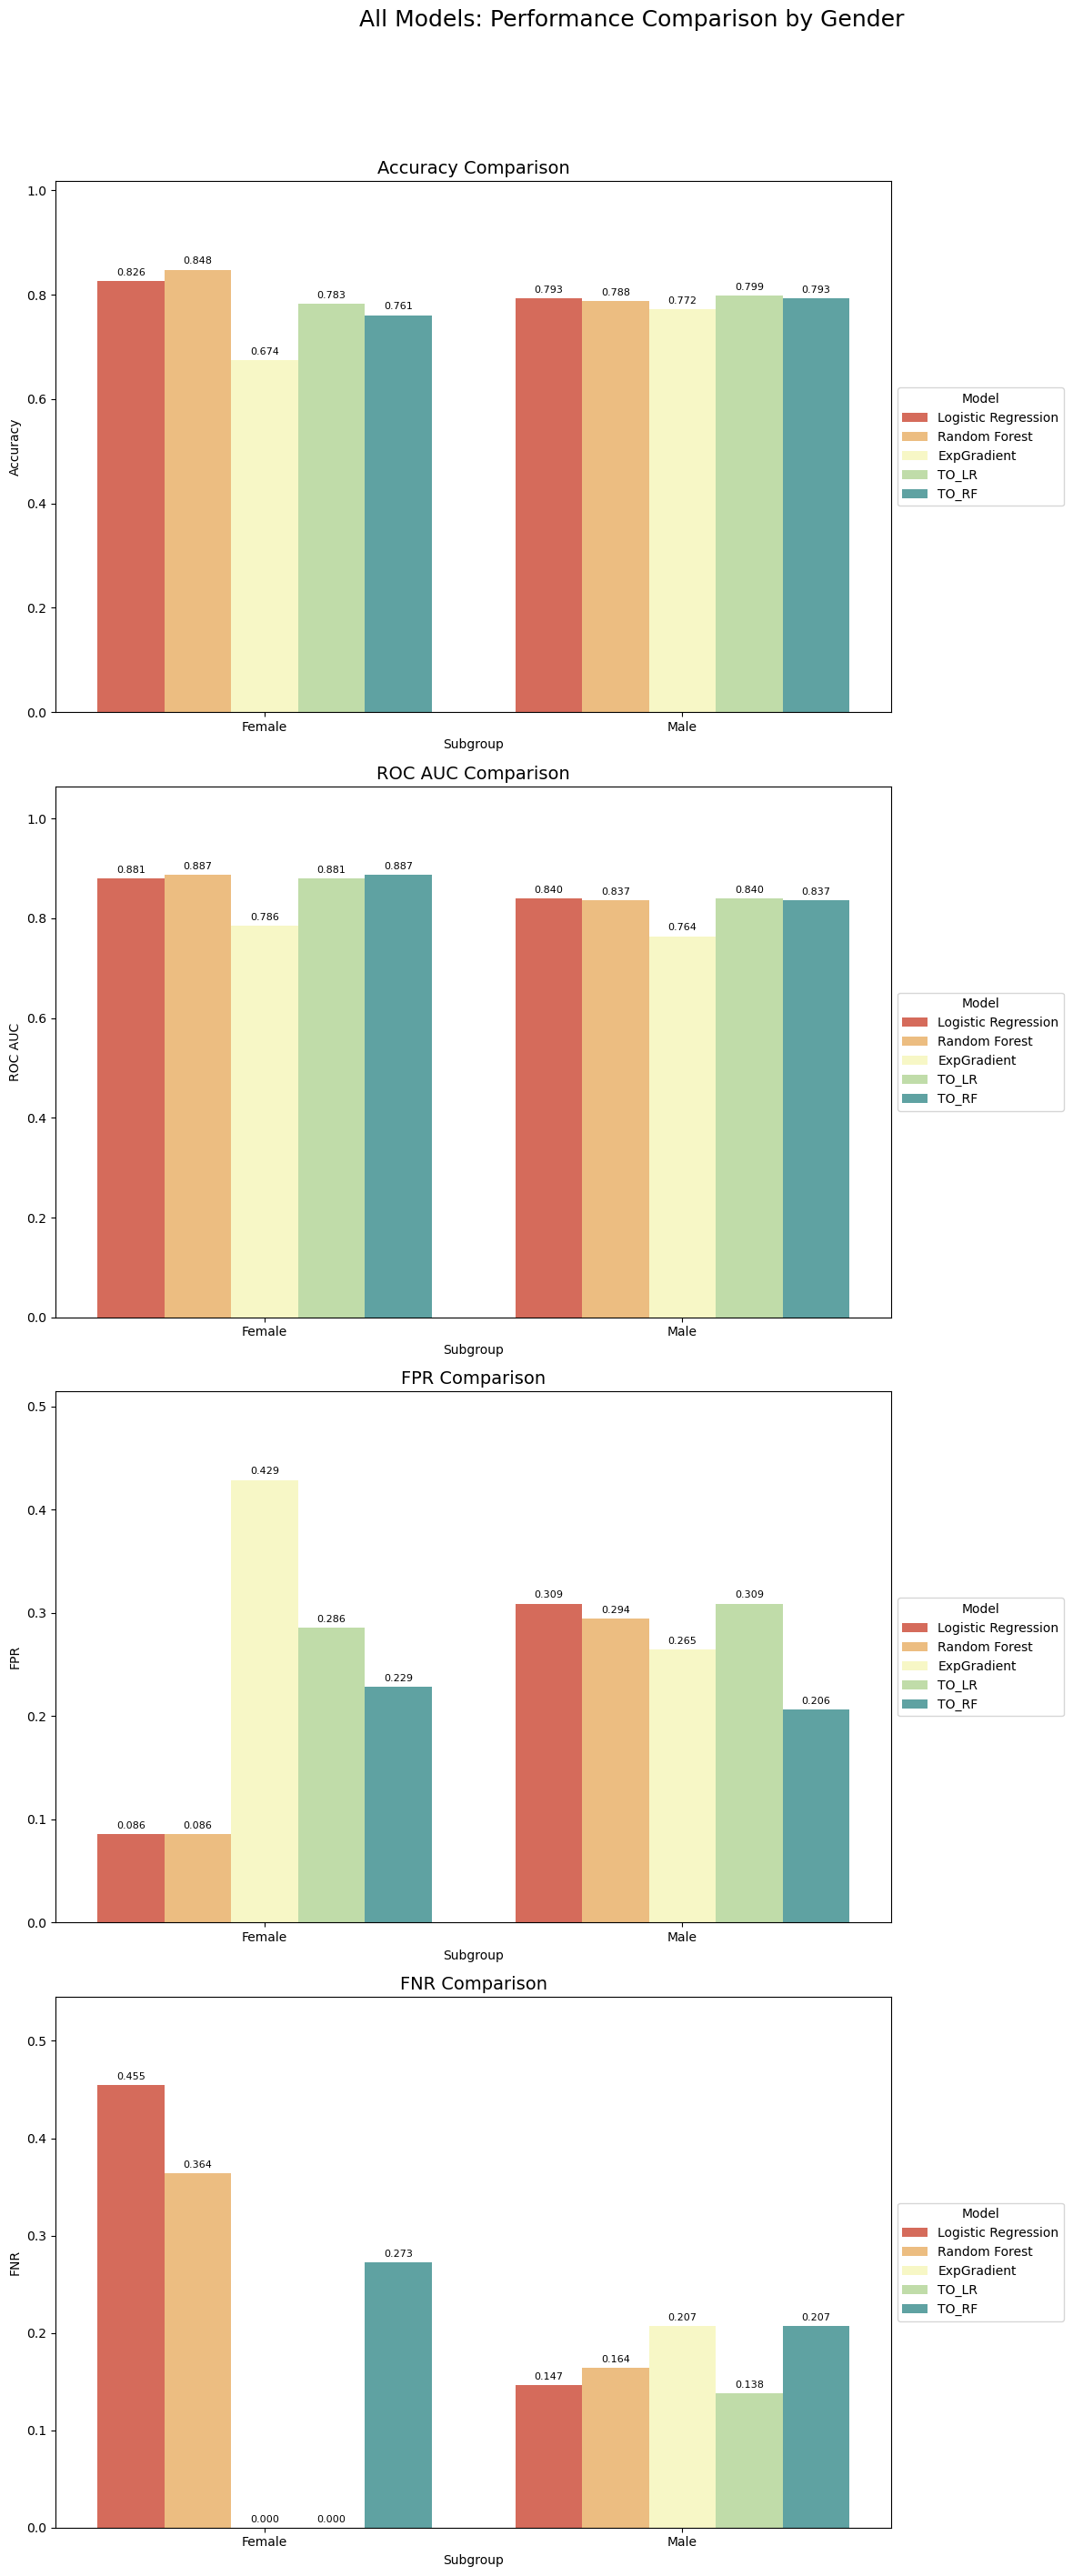

In [93]:
print("\n--- Step 6.6: Comprehensive Comparison - Performance Visualization ---")

# Ensure combined_bias_performance_df exists from Chunk 5, or initialize if first time
if 'combined_bias_performance_df' not in locals() or not isinstance(combined_bias_performance_df, pd.DataFrame):
    print("Initializing 'combined_bias_performance_df' for the first time.")
    combined_bias_performance_df = pd.DataFrame()
    # If unmitigated model results were stored in 'bias_performance_df' (from Chunk 3 script context)
    # and it should be the base for comparison, load it here.
    # For this example, we assume Chunk 5 has already created/populated combined_bias_performance_df
    # with LR, RF, and ExpGradient results.

# Concatenate new TO results for performance
temp_dfs_perf = [combined_bias_performance_df]
if not to_lr_bias_perf_df.empty: temp_dfs_perf.append(to_lr_bias_perf_df)
if not to_rf_bias_perf_df.empty: temp_dfs_perf.append(to_rf_bias_perf_df)

if len(temp_dfs_perf) > 1 or (len(temp_dfs_perf)==1 and not temp_dfs_perf[0].empty) :
    combined_bias_performance_df = pd.concat(temp_dfs_perf, ignore_index=True)
    # Remove potential duplicate rows if chunks were re-run, keeping the last occurrence
    combined_bias_performance_df.drop_duplicates(subset=['Subgroup', 'Model'], keep='last', inplace=True)
else:
    print("No new performance data to add to combined_bias_performance_df.")


if not combined_bias_performance_df.empty:
    print("\n\n--- Expanded Summary of Subgroup Performance (All Models) ---")
    print(combined_bias_performance_df.to_string())
    
    metrics_to_plot_perf_all = ['Accuracy', 'ROC AUC', 'FPR', 'FNR']
    plottable_perf_metrics_all = [
        m for m in metrics_to_plot_perf_all 
        if m in combined_bias_performance_df.columns and not combined_bias_performance_df[m].isnull().all()
    ]
    
    if plottable_perf_metrics_all:
        num_metrics_perf_all = len(plottable_perf_metrics_all)
        fig_perf_all, axes_perf_all = plt.subplots(num_metrics_perf_all, 1, figsize=(14, 7 * num_metrics_perf_all), sharex=False)
        if num_metrics_perf_all == 1: axes_perf_all = [axes_perf_all]

        fig_perf_all.suptitle('All Models: Performance Comparison by Gender', fontsize=18, y=1.01)
        
        for i, metric in enumerate(plottable_perf_metrics_all):
            ax_p = axes_perf_all[i]
            plot_df_p = combined_bias_performance_df.dropna(subset=[metric])
            if not plot_df_p.empty:
                sns.barplot(data=plot_df_p, x='Subgroup', y=metric, hue='Model', ax=ax_p, palette='Spectral')
                ax_p.set_title(f'{metric} Comparison', fontsize=14)
                ax_p.legend(title='Model', loc='center left', fontsize=10, bbox_to_anchor=(1, 0.5))
                for container in ax_p.containers:
                    labels = [f'{val:.3f}' if pd.notna(val) else 'N/A' for val in container.datavalues]
                    ax_p.bar_label(container, labels=labels, label_type='edge', fontsize=8, padding=3) # Smaller font for labels
                ax_p.margins(y=0.20)
            else:
                ax_p.text(0.5, 0.5, f"No data for {metric}", ha='center', va='center', transform=ax_p.transAxes)
                ax_p.set_title(f'{metric} Comparison (No Data)', fontsize=14)
        
        plt.tight_layout(rect=[0, 0, 0.85, 0.97]) # Adjust rect for legend
        plt.show()
    else:
        print("No plottable performance metrics in the final combined_bias_performance_df.")
else:
    print("Final combined_bias_performance_df is empty. Skipping performance visualization.")


--- Step 6.6: Comprehensive Comparison - Fairness Metrics (DP & EOpp) Visualization ---


--- Expanded Summary of Fairness Metrics (DP & EOpp - All Models) ---
  Subgroup                Model  Samples  Positive Prediction Rate (DP)  True Positive Rate (EOpp)
0   Female  Logistic Regression       46                       0.195652                   0.545455
1     Male  Logistic Regression      184                       0.652174                   0.853448
2   Female        Random Forest       46                       0.217391                   0.636364
3     Male        Random Forest      184                       0.635870                   0.836207
4   Female          ExpGradient       46                       0.565217                   1.000000
5     Male          ExpGradient      184                       0.597826                   0.793103
6   Female                TO_LR       46                       0.456522                   1.000000
7     Male                TO_LR      184       

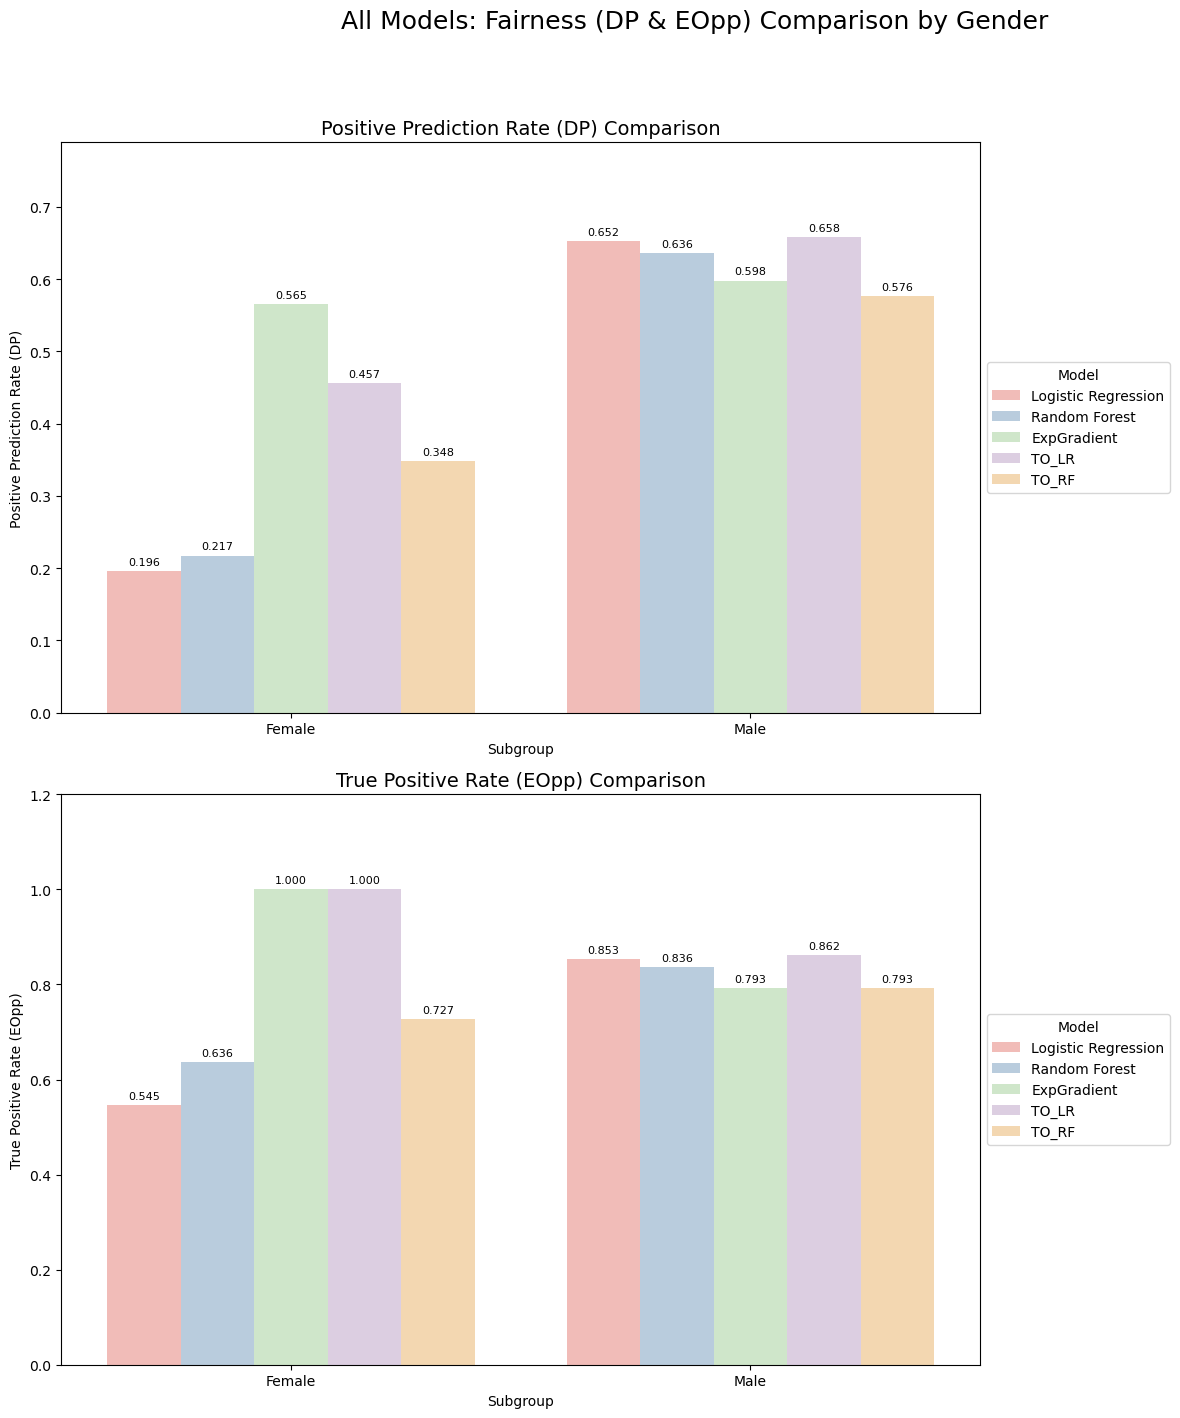


--- Chunk 6: Bias Mitigation with ThresholdOptimizer (Corrected) Finished ---


In [95]:
print("\n--- Step 6.6: Comprehensive Comparison - Fairness Metrics (DP & EOpp) Visualization ---")

# Ensure combined_fairness_dp_eopp_df exists from Chunk 5, or initialize
if 'combined_fairness_dp_eopp_df' not in locals() or not isinstance(combined_fairness_dp_eopp_df, pd.DataFrame):
    print("Initializing 'combined_fairness_dp_eopp_df' for the first time.")
    combined_fairness_dp_eopp_df = pd.DataFrame()

# Concatenate new TO results for fairness
temp_dfs_fairness = [combined_fairness_dp_eopp_df]
if not to_lr_fairness_df.empty: temp_dfs_fairness.append(to_lr_fairness_df)
if not to_rf_fairness_df.empty: temp_dfs_fairness.append(to_rf_fairness_df)

if len(temp_dfs_fairness) > 1 or (len(temp_dfs_fairness)==1 and not temp_dfs_fairness[0].empty):
    combined_fairness_dp_eopp_df = pd.concat(temp_dfs_fairness, ignore_index=True)
    # Remove potential duplicate rows
    combined_fairness_dp_eopp_df.drop_duplicates(subset=['Subgroup', 'Model'], keep='last', inplace=True)
else:
    print("No new fairness data to add to combined_fairness_dp_eopp_df.")


if not combined_fairness_dp_eopp_df.empty:
    print("\n\n--- Expanded Summary of Fairness Metrics (DP & EOpp - All Models) ---")
    print(combined_fairness_dp_eopp_df.to_string())
    
    metrics_to_plot_fairness_all = ['Positive Prediction Rate (DP)', 'True Positive Rate (EOpp)']
    plottable_fairness_metrics_all = [
        m for m in metrics_to_plot_fairness_all 
        if m in combined_fairness_dp_eopp_df.columns and not combined_fairness_dp_eopp_df[m].isnull().all()
    ]
    
    if plottable_fairness_metrics_all:
        num_metrics_fairness_all = len(plottable_fairness_metrics_all)
        fig_fairness_all, axes_fairness_all = plt.subplots(num_metrics_fairness_all, 1, figsize=(14, 7 * num_metrics_fairness_all), sharex=False)
        if num_metrics_fairness_all == 1: axes_fairness_all = [axes_fairness_all]

        fig_fairness_all.suptitle('All Models: Fairness (DP & EOpp) Comparison by Gender', fontsize=18, y=1.01)
        
        for i, metric in enumerate(plottable_fairness_metrics_all):
            ax_f = axes_fairness_all[i]
            plot_df_f = combined_fairness_dp_eopp_df.dropna(subset=[metric])
            if not plot_df_f.empty:
                sns.barplot(data=plot_df_f, x='Subgroup', y=metric, hue='Model', ax=ax_f, palette='Pastel1')
                ax_f.set_title(f'{metric} Comparison', fontsize=14)
                ax_f.legend(title='Model', loc='center left', fontsize=10, bbox_to_anchor=(1, 0.5))
                for container in ax_f.containers:
                    labels = [f'{val:.3f}' if pd.notna(val) else 'N/A' for val in container.datavalues]
                    ax_f.bar_label(container, labels=labels, label_type='edge', fontsize=8, padding=3)
                ax_f.margins(y=0.20)
            else:
                ax_f.text(0.5, 0.5, f"No data for {metric}", ha='center', va='center', transform=ax_f.transAxes)
                ax_f.set_title(f'{metric} Comparison (No Data)', fontsize=14)
        
        plt.tight_layout(rect=[0, 0, 0.85, 0.97]) # Adjust rect for legend
        plt.show()
    else:
        print("No plottable fairness metrics (DP & EOpp) in the final combined_fairness_dp_eopp_df.")
else:
    print("Final combined_fairness_dp_eopp_df is empty. Skipping fairness visualization.")

print("\n--- Chunk 6: Bias Mitigation with ThresholdOptimizer (Corrected) Finished ---")